<center>
    Weather Forecast Model
</center>

<center>
    Ⅰ.Based on the weather of the past ten days, predict the highest and lowest temperatures for the 11th day
</center>

1.Data preprocessing

In [146]:
import pandas as pd

df_weather = pd.read_csv('data_weather.csv')
print(df_weather.head())

       date  cloud_cover  sunshine  global_radiation  max_temp  mean_temp  \
0  19790101          2.0       7.0              52.0       2.3       -4.1   
1  19790102          6.0       1.7              27.0       1.6       -2.6   
2  19790103          5.0       0.0              13.0       1.3       -2.8   
3  19790104          8.0       0.0              13.0      -0.3       -2.6   
4  19790105          6.0       2.0              29.0       5.6       -0.8   

   min_temp  precipitation  pressure  snow_depth  
0      -7.5            0.4  101900.0         9.0  
1      -7.5            0.0  102530.0         8.0  
2      -7.2            0.0  102050.0         4.0  
3      -6.5            0.0  100840.0         2.0  
4      -1.4            0.0  102250.0         1.0  


In [147]:
from sklearn.preprocessing import StandardScaler

# Use linear interpolation to fill in missing values
df_weather['date'] = df_weather['date'].interpolate(method='linear')
df_weather['cloud_cover'] = df_weather['cloud_cover'].interpolate(method='linear')
df_weather['sunshine'] = df_weather['sunshine'].interpolate(method='linear')
df_weather['global_radiation'] = df_weather['global_radiation'].interpolate(method='linear')
df_weather['max_temp'] = df_weather['max_temp'].interpolate(method='linear')
df_weather['mean_temp'] = df_weather['mean_temp'].interpolate(method='linear')
df_weather['min_temp'] = df_weather['min_temp'].interpolate(method='linear')
df_weather['precipitation'] = df_weather['precipitation'].interpolate(method='linear')
df_weather['pressure'] = df_weather['pressure'].interpolate(method='linear')
df_weather['snow_depth'] = df_weather['snow_depth'].interpolate(method='linear')

# Checking duplicate records - None
duplicates = df_weather[df_weather.duplicated(subset=['date'])]
print('\duplicate date:')
print(duplicates)

# View and delete data with negative precipitation or snowfall - None
negative_precipitation = df_weather[df_weather['precipitation']< 0]
negative_snow_depth = df_weather[df_weather['snow_depth']< 0]
print('\The data that precipitation is negative')
print(negative_precipitation)
print('\The data that snow depth is negative')
print(negative_snow_depth)

# Insert new column "Temperature Difference"
df_weather['diff_temp'] = df_weather['max_temp'] - df_weather['min_temp']
df_weather = df_weather

# Z-score
features = ['cloud_cover', 'sunshine', 'global_radiation', 'max_temp',
             'mean_temp', 'min_temp','precipitation', 'pressure', 
             'snow_depth','diff_temp']
scaler = StandardScaler()
df_weather[features] = scaler.fit_transform(df_weather[features])  


for feature in features:
     mean = scaler.mean_[features.index(feature)]  
     std = scaler.scale_[features.index(feature)]  
     df_weather[feature + '_zscore'] = (df_weather[feature] - mean) / std 


thresholds = {}
for feature in features:
     std_3x = df_weather[feature].std() * 3
     thresholds[feature] = std_3x

print("特征的3倍标准差阈值:")
for feature, threshold in thresholds.items():
     print(f"{feature}: {threshold}")

for feature in features:
     mean_value = df_weather[feature].mean()
     df_weather.loc[df_weather[feature] > thresholds[feature], feature] = mean_value


df_weather.drop(columns=[feature + '_zscore' for feature in features], inplace=True)

print(df_weather.head(3)) 

\duplicate date:
Empty DataFrame
Columns: [date, cloud_cover, sunshine, global_radiation, max_temp, mean_temp, min_temp, precipitation, pressure, snow_depth]
Index: []
\The data that precipitation is negative
Empty DataFrame
Columns: [date, cloud_cover, sunshine, global_radiation, max_temp, mean_temp, min_temp, precipitation, pressure, snow_depth]
Index: []
\The data that snow depth is negative
Empty DataFrame
Columns: [date, cloud_cover, sunshine, global_radiation, max_temp, mean_temp, min_temp, precipitation, pressure, snow_depth]
Index: []
特征的3倍标准差阈值:
cloud_cover: 3.0000977819788064
sunshine: 3.0000977819788073
global_radiation: 3.0000977819788073
max_temp: 3.0000977819788073
mean_temp: 3.000097781978808
min_temp: 3.0000977819788073
precipitation: 3.0000977819788073
pressure: 3.000097781978808
snow_depth: 3.000097781978808
diff_temp: 3.0000977819788073
       date  cloud_cover  sunshine  global_radiation  max_temp  mean_temp  \
0  19790101    -1.579618  0.657802         -0.752136 -1

In [148]:
import numpy as np
import pandas as pd


pearson_corr_max_temp = df_weather.corr()['max_temp']
pearson_corr_min_temp = df_weather.corr()['min_temp']


spearman_corr_max_temp = df_weather.corr(method='spearman')['max_temp']
spearman_corr_min_temp = df_weather.corr(method='spearman')['min_temp']

# Consider the two coefficients together
combined_corr = (pearson_corr_max_temp.abs() + pearson_corr_min_temp.abs()
                 +spearman_corr_max_temp.abs() + spearman_corr_min_temp.abs()) /4

print(combined_corr)

threshold = 0.4
selected_features = combined_corr[combined_corr > threshold].index.tolist()

print('selected features based on combined correlation: \n', selected_features)

date                0.089202
cloud_cover         0.122408
sunshine            0.337460
global_radiation    0.593108
max_temp            0.907082
mean_temp           0.934198
min_temp            0.907082
precipitation       0.076482
pressure            0.086690
snow_depth          0.136514
diff_temp           0.282762
dtype: float64
selected features based on combined correlation: 
 ['global_radiation', 'max_temp', 'mean_temp', 'min_temp']


In [149]:
## Divide the data set by time sequence

def split_data(x, y, test_size):
    if not 0 <= test_size <= 1:
        raise ValueError("test_size must be between 0 and 1.")

    
    num_samples = len(x)
    num_test_samples = int(num_samples * test_size)

    # Divide the data set sequentially
    x_train = x.iloc[:-num_test_samples]
    x_test = x.iloc[-num_test_samples:]
    y_train = y.iloc[:-num_test_samples]
    y_test = y.iloc[-num_test_samples:]

    return x_train, x_test, y_train, y_test

In [150]:
from sklearn.model_selection import train_test_split

X = df_weather[['date', 'global_radiation','diff_temp','mean_temp']]  
y = df_weather[['max_temp', 'min_temp']]       


X_train_val, X_test, y_train_val, y_test = split_data(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = split_data(X_train_val, y_train_val, test_size=0.25)


print("Size of the training set: ", X_train.shape)
print("Size of the validation set: ", X_val.shape)
print("Size of the testing set: ", X_test.shape)


train_data = pd.concat([X_train, y_train], axis=1)
val_data = pd.concat([X_val, y_val], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

train_data.to_csv('train.csv', index=False)
val_data.to_csv('val.csv', index=False)
test_data.to_csv('test.csv', index=False)


train_df_weather = pd.read_csv('train.csv')
val_df_weather = pd.read_csv('val.csv')
test_df_weather = pd.read_csv('test.csv')

print('Training set: ')
print(test_df_weather.head())
print('\nValidation set:')
print(val_df_weather.head())
print('\nTest set:')
print(test_df_weather.head())

Size of the training set:  (9205, 4)
Size of the validation set:  (3068, 4)
Size of the testing set:  (3068, 4)
Training set: 
       date  global_radiation  diff_temp  mean_temp  max_temp  min_temp
0  20120808          0.529810   0.981831   1.348412  1.664123  1.340546
1  20120809          1.631833   1.528808   1.453151  1.755645  1.058922
2  20120810          1.519382   0.382761   1.645173  1.328541  1.359321
3  20120811          1.440666   1.138111   1.383325  1.755645  1.340546
4  20120812          1.103312   0.174389   1.680086  1.282779  1.453196

Validation set:
       date  global_radiation  diff_temp  mean_temp  max_temp  min_temp
0  20040315         -0.785871   0.200436  -0.083024  0.306541  0.232825
1  20040316          0.158720  -1.023751   0.458129 -0.105310  0.608324
2  20040317         -0.684665  -0.216309  -0.117937 -0.227340 -0.123899
3  20040318         -0.369801  -0.659100  -0.135394 -0.395131 -0.011250
4  20040319         -0.819607  -0.268402  -0.222676 -0.166325 -0

2.Baseline model - Moving average

In [70]:
def moving_average(data, window_size):
    averages = []
    for i in range(len(data) - window_size + 1):
        window = data[i:i + window_size]
        average = np.mean(window)
        averages.append(average)
    return np.array(averages)

window_size = 10

# Calculate the moving average for each feature in the training set
X_train_ma = np.zeros((X_train.shape[0] - window_size + 1, X_train.shape[1]))
for i in range(X_train.shape[1]):
    X_train_ma[:, i] = moving_average(X_train.iloc[:, i], window_size)

y_train_max_ma = moving_average(y_train['max_temp'].values, window_size)
y_train_min_ma = moving_average(y_train['min_temp'].values, window_size)

# create model
class MovingAverageModel:
    def __init__(self):
        self.window_size = None
        self.coefficients = None

    def fit(self, X, y):
        self.window_size = X.shape[1]
        self.coefficients = np.linalg.lstsq(X, y, rcond=None)[0]

    def predict(self, X):
        return np.dot(X, self.coefficients)
        
        

In [71]:
# create and train model
model_max_temp = MovingAverageModel()
model_min_temp = MovingAverageModel()
model_max_temp.fit(X_train_ma, y_train_max_ma)
model_min_temp.fit(X_train_ma, y_train_min_ma)

# evaluate model
X_val_ma = np.zeros((X_val.shape[0] - window_size + 1, X_val.shape[1]))
for i in range(X_val.shape[1]):
    X_val_ma[:, i] = moving_average(X_val.iloc[:, i], window_size)

y_val_pred_max = model_max_temp.predict(X_val_ma)
y_val_pred_min = model_min_temp.predict(X_val_ma)

# predict
X_test_ma = np.zeros((X_test.shape[0] - window_size + 1, X_test.shape[1]))
for i in range(X_test.shape[1]):
    X_test_ma[:, i] = moving_average(X_test.iloc[:, i], window_size)

y_test_pred_max_ma = model_max_temp.predict(X_test_ma)
y_test_pred_min_ma = model_min_temp.predict(X_test_ma)



In [72]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

tscv = TimeSeriesSplit(n_splits=5)

# Initializes the result store
mse_scores_max = []
mse_scores_min = []
rmse_scores_max = []
rmse_scores_min = []
mae_scores_max = []
mae_scores_min = []
r2_scores_max = []
r2_scores_min = []
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
# TimeSeriesSplit
for train_index, val_index in tscv.split(X_train):
   
    X_train_cv, X_val_cv = X_train[train_index], X_train[val_index]
    y_train_max_cv, y_val_max_cv = y_train[train_index, 0], y_train[val_index, 0]
    y_train_min_cv, y_val_min_cv = y_train[train_index, 1], y_train[val_index, 1]
    
   
    X_train_ma = np.zeros((X_train_cv.shape[0] - window_size + 1, X_train_cv.shape[1]))
    X_val_ma = np.zeros((X_val_cv.shape[0] - window_size + 1, X_val_cv.shape[1]))
    for i in range(X_train_cv.shape[1]):
        X_train_ma[:, i] = moving_average(X_train_cv[:, i], window_size)
        X_val_ma[:, i] = moving_average(X_val_cv[:, i], window_size)
    
    y_train_max_ma = moving_average(y_train_max_cv, window_size)
    y_train_min_ma = moving_average(y_train_min_cv, window_size)
    
    # Create the corresponding moving average for the validation set label
    y_val_max_ma = moving_average(y_val_max_cv, window_size)
    y_val_min_ma = moving_average(y_val_min_cv, window_size)
    
    # train
    model_max_temp = MovingAverageModel()
    model_min_temp = MovingAverageModel()
    model_max_temp.fit(X_train_ma, y_train_max_ma)
    model_min_temp.fit(X_train_ma, y_train_min_ma)
    
    # predict
    y_val_pred_max = model_max_temp.predict(X_val_ma)
    y_val_pred_min = model_min_temp.predict(X_val_ma)
    
    mse_max = mean_squared_error(y_val_max_ma, y_val_pred_max)
    mse_min = mean_squared_error(y_val_min_ma, y_val_pred_min)
    rmse_max = np.sqrt(mse_max)
    rmse_min = np.sqrt(mse_min)
    mae_max = mean_absolute_error(y_val_max_ma, y_val_pred_max)
    mae_min = mean_absolute_error(y_val_min_ma, y_val_pred_min)
    r2_max = r2_score(y_val_max_ma, y_val_pred_max)
    r2_min = r2_score(y_val_min_ma, y_val_pred_min)
    
    mse_scores_max.append(mse_max)
    mse_scores_min.append(mse_min)
    rmse_scores_max.append(rmse_max)
    rmse_scores_min.append(rmse_min)
    mae_scores_max.append(mae_max)
    mae_scores_min.append(mae_min)
    r2_scores_max.append(r2_max)
    r2_scores_min.append(r2_min)


print("Cross-validation results:")
print(f"Average MSE of 'max_temp': {np.mean(mse_scores_max):.2f}")
print(f"Average MSE of 'min_temp': {np.mean(mse_scores_min):.2f}")
print(f"Average RMSE of 'max_temp': {np.mean(rmse_scores_max):.2f}")
print(f"Average RMSE of 'min_temp': {np.mean(rmse_scores_min):.2f}")
print(f"Average MAE of 'max_temp': {np.mean(mae_scores_max):.2f}")
print(f"Average MAE of 'min_temp': {np.mean(mae_scores_min):.2f}")
print(f"Average R² of 'max_temp': {np.mean(r2_scores_max):.2f}")
print(f"Average R² of 'min_temp': {np.mean(r2_scores_min):.2f}")


Cross-validation results:
Average MSE of 'max_temp': 0.00
Average MSE of 'min_temp': 0.00
Average RMSE of 'max_temp': 0.04
Average RMSE of 'min_temp': 0.04
Average MAE of 'max_temp': 0.03
Average MAE of 'min_temp': 0.03
Average R² of 'max_temp': 1.00
Average R² of 'min_temp': 1.00


In [73]:
# evaluate
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# RMSE
mse_max_ma = mean_squared_error(y_test['max_temp'].values[window_size - 1:], y_test_pred_max_ma)
mse_min_ma = mean_squared_error(y_test['min_temp'].values[window_size - 1:], y_test_pred_min_ma)

# MSE
mse_max_ma = mean_squared_error(y_test['max_temp'].values[window_size - 1:], y_test_pred_max_ma)
mse_min_ma = mean_squared_error(y_test['min_temp'].values[window_size - 1:], y_test_pred_min_ma)

# MAE
mae_max_ma = mean_absolute_error(y_test['max_temp'].values[window_size - 1:], y_test_pred_max_ma)
mae_min_ma = mean_absolute_error(y_test['min_temp'].values[window_size - 1:], y_test_pred_min_ma)

# R2
r2_max_ma = r2_score(y_test['max_temp'].values[window_size - 1:], y_test_pred_max_ma)
r2_min_ma = r2_score(y_test['min_temp'].values[window_size - 1:], y_test_pred_min_ma)

print("RMSE of 'max_temp' in test set: {:.2f}".format(np.sqrt(mse_max_ma)))
print("RMSE of 'min_temp' in test set: {:.2f}".format(np.sqrt(mse_min_ma)))

print("MSE of 'max_temp' in test set: {:.2f}".format(mse_max_ma))
print("MSE of 'min_temp' in test set: {:.2f}".format(mse_min_ma))

print("MAE of 'max_temp' in test set: {:.2f}".format(mae_max_ma))
print("MAE of 'min_temp' in test set: {:.2f}".format(mae_min_ma))

print("R² of 'max_temp' in test set: {:.2f}".format(r2_max_ma))
print("R² of 'min_temp' in test set: {:.2f}".format(r2_min_ma))

RMSE of 'max_temp' in test set: 0.46
RMSE of 'min_temp' in test set: 0.52
MSE of 'max_temp' in test set: 0.21
MSE of 'min_temp' in test set: 0.27
MAE of 'max_temp' in test set: 0.36
MAE of 'min_temp' in test set: 0.41
R² of 'max_temp' in test set: 0.79
R² of 'min_temp' in test set: 0.72


3.Random Forest

In [74]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def create_features_and_target(df, n_days=10):
    df = df.copy()
    for i in range(1, n_days + 1):
        df[f'global_radiation_{i}d'] = df['global_radiation'].shift(i)
        df[f'diff_temp_{i}d'] = df['diff_temp'].shift(i)
        df[f'mean_temp_{i}d'] = df['mean_temp'].shift(i)
    
    df = df.dropna().reset_index(drop=True)
    X = df[[f'global_radiation_{i}d' for i in range(1, n_days + 1)] +
           [f'diff_temp_{i}d' for i in range(1, n_days + 1)] +
           [f'mean_temp_{i}d' for i in range(1, n_days + 1)]]
    y_max_rf = df['max_temp']
    y_min_rf = df['min_temp']
    return X, y_max_rf, y_min_rf


X_train_rf, y_train_max_rf, y_train_min_rf = create_features_and_target(train_df_weather)
X_val_rf, y_val_max_rf, y_val_min_rf = create_features_and_target(val_df_weather)
X_test_rf, y_test_max_rf, y_test_min_rf = create_features_and_target(test_df_weather)

In [75]:
# create and train
rf_max = RandomForestRegressor(n_estimators=100, random_state=42)
rf_max.fit(X_train_rf, y_train_max_rf)

rf_min = RandomForestRegressor(n_estimators=100, random_state=42)
rf_min.fit(X_train_rf, y_train_min_rf)

# pred
y_val_pred_max_rf = rf_max.predict(X_val_rf)
y_val_pred_min_rf = rf_min.predict(X_val_rf)

# pred
y_test_pred_max_rf = rf_max.predict(X_test_rf)
y_test_pred_min_rf = rf_min.predict(X_test_rf)


In [76]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# 
X, y_max, y_min = create_features_and_target(train_df_weather)

# 5 fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)


mse_scores_max = []
mse_scores_min = []
rmse_scores_max = []
rmse_scores_min = []
mae_scores_max = []
mae_scores_min = []
r2_scores_max = []
r2_scores_min = []

# initialize K-fold
for train_index, val_index in kf.split(X):
    X_train_cv, X_val_cv = X.iloc[train_index], X.iloc[val_index]
    y_train_max_cv, y_val_max_cv = y_max.iloc[train_index], y_max.iloc[val_index]
    y_train_min_cv, y_val_min_cv = y_min.iloc[train_index], y_min.iloc[val_index]
    
  
    rf_max = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_max.fit(X_train_cv, y_train_max_cv)

    rf_min = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_min.fit(X_train_cv, y_train_min_cv)


    y_val_pred_max_rf = rf_max.predict(X_val_cv)
    y_val_pred_min_rf = rf_min.predict(X_val_cv)


    mse_max = mean_squared_error(y_val_max_cv, y_val_pred_max_rf)
    mse_min = mean_squared_error(y_val_min_cv, y_val_pred_min_rf)
    rmse_max = np.sqrt(mse_max)
    rmse_min = np.sqrt(mse_min)
    
    mse_scores_max.append(mse_max)
    mse_scores_min.append(mse_min)
    rmse_scores_max.append(rmse_max)
    rmse_scores_min.append(rmse_min)
    mae_scores_max.append(mean_absolute_error(y_val_max_cv, y_val_pred_max_rf))
    mae_scores_min.append(mean_absolute_error(y_val_min_cv, y_val_pred_min_rf))
    r2_scores_max.append(r2_score(y_val_max_cv, y_val_pred_max_rf))
    r2_scores_min.append(r2_score(y_val_min_cv, y_val_pred_min_rf))


print("Cross-validation results:")
print(f"Average MSE of 'max_temp': {np.mean(mse_scores_max):.2f}")
print(f"Average MSE of 'min_temp': {np.mean(mse_scores_min):.2f}")
print(f"Average RMSE of 'max_temp': {np.mean(rmse_scores_max):.2f}")
print(f"Average RMSE of 'min_temp': {np.mean(rmse_scores_min):.2f}")
print(f"Average MAE of 'max_temp': {np.mean(mae_scores_max):.2f}")
print(f"Average MAE of 'min_temp': {np.mean(mae_scores_min):.2f}")
print(f"Average R² of 'max_temp': {np.mean(r2_scores_max):.2f}")
print(f"Average R² of 'min_temp': {np.mean(r2_scores_min):.2f}")


Cross-validation results:
Average MSE of 'max_temp': 0.15
Average MSE of 'min_temp': 0.14
Average RMSE of 'max_temp': 0.39
Average RMSE of 'min_temp': 0.37
Average MAE of 'max_temp': 0.30
Average MAE of 'min_temp': 0.30
Average R² of 'max_temp': 0.85
Average R² of 'min_temp': 0.86


In [77]:
# evaluate

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# RMSE)
rmse_max_rf = np.sqrt(mean_squared_error(y_test_max_rf, y_test_pred_max_rf))
rmse_min_rf = np.sqrt(mean_squared_error(y_test_min_rf, y_test_pred_min_rf))

# MSE
mse_max_rf = mean_squared_error(y_test_max_rf, y_test_pred_max_rf)
mse_min_rf = mean_squared_error(y_test_min_rf, y_test_pred_min_rf)

# MAE
mae_max_rf = mean_absolute_error(y_test_max_rf, y_test_pred_max_rf)
mae_min_rf = mean_absolute_error(y_test_min_rf, y_test_pred_min_rf)

# R²
r2_max_rf = r2_score(y_test_max_rf, y_test_pred_max_rf)
r2_min_rf = r2_score(y_test_min_rf, y_test_pred_min_rf)

print(f"RMSE of 'max_temp' in test set: {rmse_max_rf}")
print(f"RMSE of 'min_temp' in test set: {rmse_min_rf}")

print(f"MSE of 'max_temp' in test set: {mse_max_rf}")
print(f"MSE of 'min_temp' in test set: {mse_min_rf}")

print(f"MAE of 'max_temp' in test set: {mae_max_rf}")
print(f"MAE of 'min_temp' in test set: {mae_min_rf}")

print(f"R² of 'max_temp' in test set: {r2_max_rf}")
print(f"R² of 'min_temp' in test set: {r2_min_rf}")

RMSE of 'max_temp' in test set: 0.4041829141188286
RMSE of 'min_temp' in test set: 0.39214930819146954
MSE of 'max_temp' in test set: 0.1633638280655884
MSE of 'min_temp' in test set: 0.15378107991504816
MAE of 'max_temp' in test set: 0.3105157689668827
MAE of 'min_temp' in test set: 0.3153303253808187
R² of 'max_temp' in test set: 0.8352520531486846
R² of 'min_temp' in test set: 0.837707867413086


In [ ]:
#Select the best parameters and optimize the model

from sklearn.model_selection import GridSearchCV


param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# GridSearchCV 
rf_max = RandomForestRegressor(random_state=42)
grid_search_max = GridSearchCV(estimator=rf_max, param_grid=param_grid,
                               cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
grid_search_max.fit(X_train_rf, y_train_max_rf)

rf_min = RandomForestRegressor(random_state=42)
grid_search_min = GridSearchCV(estimator=rf_min, param_grid=param_grid,
                               cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
grid_search_min.fit(X_train_rf, y_train_min_rf)

print(f"Optimum parameter (max_temp): {grid_search_max.best_params_}")
print(f"Optimum parameter (min_temp): {grid_search_min.best_params_}")


Fitting 5 folds for each of 108 candidates, totalling 540 fits


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/anaconda3/lib/python

[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.0s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.6s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.6s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.6s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] 

In [ ]:

print(f"Optimum parameter (max_temp): {grid_search_max.best_params_}")
print(f"Optimum parameter (min_temp): {grid_search_min.best_params_}")

Optimum parameter (max_temp): {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Optimum parameter (min_temp): {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [ ]:
# cross validation

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# The best parameters from the previous GridSearchCV results
best_params_max = grid_search_max.best_params_
best_params_min = grid_search_min.best_params_

X, y_max, y_min = create_features_and_target(train_df_weather)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mse_scores_max = []
mse_scores_min = []
rmse_scores_max = []
rmse_scores_min = []
mae_scores_max = []
mae_scores_min = []
r2_scores_max = []
r2_scores_min = []

for train_index, val_index in kf.split(X):
    X_train_cv, X_val_cv = X.iloc[train_index], X.iloc[val_index]
    y_train_max_cv, y_val_max_cv = y_max.iloc[train_index], y_max.iloc[val_index]
    y_train_min_cv, y_val_min_cv = y_min.iloc[train_index], y_min.iloc[val_index]
    
    rf_max = RandomForestRegressor(**best_params_max, random_state=42)
    rf_max.fit(X_train_cv, y_train_max_cv)

    rf_min = RandomForestRegressor(**best_params_min, random_state=42)
    rf_min.fit(X_train_cv, y_train_min_cv)

    y_val_pred_max_rf = rf_max.predict(X_val_cv)
    y_val_pred_min_rf = rf_min.predict(X_val_cv)

    mse_max = mean_squared_error(y_val_max_cv, y_val_pred_max_rf)
    mse_min = mean_squared_error(y_val_min_cv, y_val_pred_min_rf)
    rmse_max = np.sqrt(mse_max)
    rmse_min = np.sqrt(mse_min)
    
    mse_scores_max.append(mse_max)
    mse_scores_min.append(mse_min)
    rmse_scores_max.append(rmse_max)
    rmse_scores_min.append(rmse_min)
    mae_scores_max.append(mean_absolute_error(y_val_max_cv, y_val_pred_max_rf))
    mae_scores_min.append(mean_absolute_error(y_val_min_cv, y_val_pred_min_rf))
    r2_scores_max.append(r2_score(y_val_max_cv, y_val_pred_max_rf))
    r2_scores_min.append(r2_score(y_val_min_cv, y_val_pred_min_rf))

print("Cross-validation results with best parameters:")
print(f"Average MSE of 'max_temp': {np.mean(mse_scores_max):.2f}")
print(f"Average MSE of 'min_temp': {np.mean(mse_scores_min):.2f}")
print(f"Average RMSE of 'max_temp': {np.mean(rmse_scores_max):.2f}")
print(f"Average RMSE of 'min_temp': {np.mean(rmse_scores_min):.2f}")
print(f"Average MAE of 'max_temp': {np.mean(mae_scores_max):.2f}")
print(f"Average MAE of 'min_temp': {np.mean(mae_scores_min):.2f}")
print(f"Average R² of 'max_temp': {np.mean(r2_scores_max):.2f}")
print(f"Average R² of 'min_temp': {np.mean(r2_scores_min):.2f}")


Cross-validation results with best parameters:
Average MSE of 'max_temp': 0.19
Average MSE of 'min_temp': 0.21
Average RMSE of 'max_temp': 0.44
Average RMSE of 'min_temp': 0.46
Average MAE of 'max_temp': 0.34
Average MAE of 'min_temp': 0.37
Average R² of 'max_temp': 0.81
Average R² of 'min_temp': 0.79


4.LSTM

In [78]:
train_df_weather = train_df_weather.sort_values('date')
val_df_weather = val_df_weather.sort_values('date')
test_df_weather = test_df_weather.sort_values('date')

features = ['global_radiation', 'diff_temp', 'mean_temp']
target = ['max_temp', 'min_temp']

train_X_rnn = train_df_weather[features].values
train_y_rnn = train_df_weather[target].values

val_X_rnn = val_df_weather[features].values
val_y_rnn = val_df_weather[target].values

test_X_rnn = test_df_weather[features].values
test_y_rnn = test_df_weather[target].values

# Create a time window function
def create_time_series(X, y, time_steps=10):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 10
X_train_rnn, y_train_rnn = create_time_series(train_X_rnn, train_y_rnn, time_steps)
X_val_rnn, y_val_rnn = create_time_series(val_X_rnn, val_y_rnn, time_steps)
X_test_rnn, y_test_rnn = create_time_series(test_X_rnn, test_y_rnn, time_steps)

print("Size of the training set:", X_train_rnn.shape, y_train_rnn.shape)
print("Size of the validation set:", X_val_rnn.shape, y_val_rnn.shape)
print("Size of the testing set:", X_test_rnn.shape, y_test_rnn.shape)


Size of the training set: (9195, 10, 3) (9195, 2)
Size of the validation set: (3058, 10, 3) (3058, 2)
Size of the testing set: (3058, 10, 3) (3058, 2)


In [79]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# create model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(time_steps, len(features))))
model.add(Dense(2))  

model.compile(optimizer='adam', loss='mse', run_eagerly=True)
model.summary()



/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_21 (LSTM)                  │ (None, 50)             │        10,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_121 (Dense)               │ (None, 2)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,902 (42.59 KB)

 Trainable params: 10,902 (42.59 KB)

 Non-trainable params: 0 (0.00 B)

In [81]:
# train
history = model.fit(X_train_rnn, y_train_rnn, epochs=50, batch_size=32, validation_data=(X_val_rnn, y_val_rnn))

Epoch 1/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 0.3555 - val_loss: 0.1457
Epoch 2/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 0.1445 - val_loss: 0.1354
Epoch 3/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 0.1376 - val_loss: 0.1335
Epoch 4/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.1382 - val_loss: 0.1318
Epoch 5/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 0.1345 - val_loss: 0.1298
Epoch 6/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.1332 - val_loss: 0.1327
Epoch 7/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 0.1344 - val_loss: 0.1336
Epoch 8/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.1310 - val_loss: 0.1316
Epoch 9/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.1358 - val_loss: 0.1292
Epoch 10/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 0.1336 - val_loss: 0.1302
Epoch 11/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 0.1282 - val_loss: 0.1367
Epoch 12/50
288/288 ━━━━━━━━━━

In [80]:
# save model
model.save('rnn_weather_model.h5')



96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1381
The loss in testing set: 0.16117988526821136


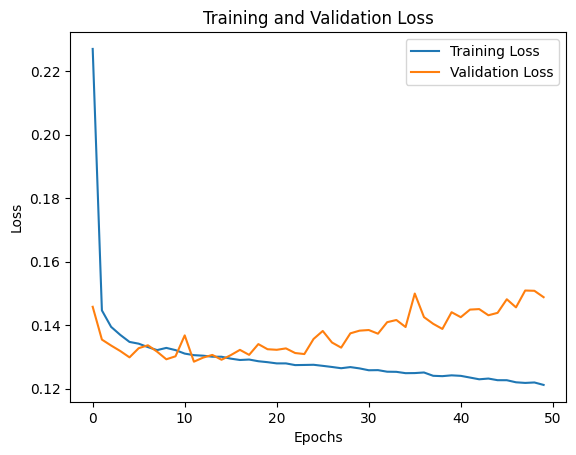

In [82]:
import matplotlib.pyplot as plt

# evaludate
loss = model.evaluate(X_test_rnn, y_test_rnn)
print('The loss in testing set:', loss)

# loss function
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [83]:
# evaluate
y_val_pred_rnn = model.predict(X_val_rnn)
y_test_pred_rnn = model.predict(X_test_rnn)

# RMSE
rmse_max_rnn = np.sqrt(mean_squared_error(y_test_rnn[:, 0], y_test_pred_rnn[:, 0]))
rmse_min_rnn = np.sqrt(mean_squared_error(y_test_rnn[:, 1], y_test_pred_rnn[:, 1]))

# MSE
mse_max_rnn = mean_squared_error(y_test_rnn[:, 0], y_test_pred_rnn[:, 0])
mse_min_rnn = mean_squared_error(y_test_rnn[:, 1], y_test_pred_rnn[:, 1])

# MAE
mae_max_rnn = mean_absolute_error(y_test_rnn[:, 0], y_test_pred_rnn[:, 0])
mae_min_rnn = mean_absolute_error(y_test_rnn[:, 1], y_test_pred_rnn[:, 1])

# R²
r2_max_rnn = r2_score(y_test_rnn[:, 0], y_test_pred_rnn[:, 0])
r2_min_rnn = r2_score(y_test_rnn[:, 1], y_test_pred_rnn[:, 1])

print(f"RMSE of 'max_temp' in test set: {rmse_max_rnn}")
print(f"RMSE of 'min_temp' in test set: {rmse_min_rnn}")

print(f"MSE of 'max_temp' in test set: {mse_max_rnn}")
print(f"MSE of 'min_temp' in test set: {mse_min_rnn}")

print(f"MAE of 'max_temp' in test set: {mae_max_rnn}")
print(f"MAE of 'min_temp' in test set: {mae_min_rnn}")

print(f"R² of 'max_temp' in test set: {r2_max_rnn}")
print(f"R² of 'min_temp' in test set: {r2_min_rnn}")


96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
RMSE of 'max_temp' in test set: 0.4010163099390085
RMSE of 'min_temp' in test set: 0.40192748090429864
MSE of 'max_temp' in test set: 0.16081408083709892
MSE of 'min_temp' in test set: 0.16154569990607534
MAE of 'max_temp' in test set: 0.30369115058371127
MAE of 'min_temp' in test set: 0.3181266719998786
R² of 'max_temp' in test set: 0.8378234034032515
R² of 'min_temp' in test set: 0.8295135125693893


In [ ]:
# Permutation Feature Importance
from sklearn.inspection import permutation_importance

X_test_rnn_reshaped = X_test_rnn.reshape(X_test_rnn.shape[0], -1)

def custom_scoring(estimator, X, y):
    X_reshaped7 = X.reshape(-1, time_steps, len(features))
    y_pred7 = estimator.predict(X_reshaped7)
    return -np.mean((y_pred7 - y) ** 2)

# use scikit-learn  permutation_importance
# result_rnn = permutation_importance(estimator=model, X=X_test_rnn_reshaped, y=y_test_rnn, n_repeats=10, random_state=42, scoring=custom_scoring, n_jobs=-1)

# # show 
# for i in range(len(features)):
#     print(f"Feature: {features[i]}, Importance: {result_rnn.importances_mean[i]}")



In [151]:
# cross validation

from sklearn.model_selection import TimeSeriesSplit
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
import numpy as np
import pandas as pd

features = ['global_radiation', 'diff_temp', 'mean_temp']
target = ['max_temp', 'min_temp']
X = df_weather[features].values  
y = df_weather[target].values  


def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=input_shape))
    model.add(Dense(2))  
    model.compile(optimizer=Adam(), loss='mse')
    return model

# TimeSeriesSplit
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

results = {
    'loss': [],
    'rmse_max': [],
    'rmse_min': [],
    'mse_max': [],
    'mse_min': [],
    'mae_max': [],
    'mae_min': [],
    'r2_max': [],
    'r2_min': []
}

for train_index, val_index in tscv.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    time_steps = 10
    X_train_rnn, y_train_rnn = create_time_series(X_train, y_train, time_steps)
    X_val_rnn, y_val_rnn = create_time_series(X_val, y_val, time_steps)

    model = create_lstm_model((time_steps, len(features)))
    history = model.fit(X_train_rnn, y_train_rnn, epochs=50, batch_size=32, validation_data=(X_val_rnn, y_val_rnn), verbose=0)

    loss = model.evaluate(X_val_rnn, y_val_rnn, verbose=0)
    y_val_pred_rnn = model.predict(X_val_rnn)

    mse_max = mean_squared_error(y_val_rnn[:, 0], y_val_pred_rnn[:, 0])
    mse_min = mean_squared_error(y_val_rnn[:, 1], y_val_pred_rnn[:, 1])
    rmse_max = np.sqrt(mse_max)
    rmse_min = np.sqrt(mse_min)
    mae_max = mean_absolute_error(y_val_rnn[:, 0], y_val_pred_rnn[:, 0])
    mae_min = mean_absolute_error(y_val_rnn[:, 1], y_val_pred_rnn[:, 1])
    r2_max = r2_score(y_val_rnn[:, 0], y_val_pred_rnn[:, 0])
    r2_min = r2_score(y_val_rnn[:, 1], y_val_pred_rnn[:, 1])

    results['loss'].append(loss)
    results['rmse_max'].append(rmse_max)
    results['rmse_min'].append(rmse_min)
    results['mse_max'].append(mse_max)
    results['mse_min'].append(mse_min)
    results['mae_max'].append(mae_max)
    results['mae_min'].append(mae_min)
    results['r2_max'].append(r2_max)
    results['r2_min'].append(r2_min)
    print(f'Fold {len(results["loss"])}, Loss: {loss}, RMSE Max: {rmse_max}, RMSE Min: {rmse_min}')

print(f'Average Loss: {np.mean(results["loss"])}')
print(f'Average RMSE of max_temp: {np.mean(results["rmse_max"])}')
print(f'Average RMSE of min_temp: {np.mean(results["rmse_min"])}')
print(f'Average MSE of max_temp: {np.mean(results["mse_max"])}')
print(f'Average MSE of min_temp: {np.mean(results["mse_min"])}')
print(f'Average MAE of max_temp: {np.mean(results["mae_max"])}')
print(f'Average MAE of min_temp: {np.mean(results["mae_min"])}')
print(f'Average R² of max_temp: {np.mean(results["r2_max"])}')
print(f'Average R² of min_temp: {np.mean(results["r2_min"])}')


/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold 1, Loss: 0.13885636627674103, RMSE Max: 0.3754215137386663, RMSE Min: 0.36982617017735475


/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold 2, Loss: 0.13154767453670502, RMSE Max: 0.3736972104564844, RMSE Min: 0.35134840267764916


/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold 3, Loss: 0.1388428658246994, RMSE Max: 0.38979825589716455, RMSE Min: 0.35460278307847803


/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold 4, Loss: 0.1300431191921234, RMSE Max: 0.3595533040383151, RMSE Min: 0.3616734033677247


/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold 5, Loss: 0.16811782121658325, RMSE Max: 0.4009343299207795, RMSE Min: 0.41891197416440723
Average Loss: 0.14148156940937043
Average RMSE of max_temp: 0.37988092281028196
Average RMSE of min_temp: 0.3712725466931227
Average MSE of max_temp: 0.14451210274703088
Average MSE of min_temp: 0.13845102455622027
Average MAE of max_temp: 0.2945731504685038
Average MAE of min_temp: 0.2968711330170186
Average R² of max_temp: 0.8522027597069375
Average R² of min_temp: 0.8566586006539417


5.Transformer

In [84]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, LayerNormalization, MultiHeadAttention, Dropout, GlobalAveragePooling1D, Add
from tensorflow.keras.optimizers import Adam

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = Add()([x, inputs])

    # Feed Forward Part
    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return Add()([x, res])

def build_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
    inputs = Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = Dense(dim, activation="relu")(x)
        x = Dropout(mlp_dropout)(x)
    outputs = Dense(2)(x)  
    return Model(inputs, outputs)


In [85]:
input_shape = (time_steps, len(features))
model1 = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model1.compile(
    loss="mean_squared_error",
    optimizer=Adam(learning_rate=1e-4),
)

model1.summary()

Model: "functional_54"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_32      │ (None, 10, 3)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 3)     │          6 │ input_layer_32[0… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 3)     │     15,363 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_131         │ (None, 10, 3)     │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_80 (Add)        │ (None, 10, 3)     │          0 │ dropout_131[0][0… │
│                     │                   │            │ input_layer_32[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 3)     │          6 │ add_80[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_122 (Dense)   │ (None, 10, 4)     │         16 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_132         │ (None, 10, 4)     │          0 │ dense_122[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_123 (Dense)   │ (None, 10, 3)     │         15 │ dropout_132[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_81 (Add)        │ (None, 10, 3)     │          0 │ dense_123[0][0],  │
│                     │                   │            │ add_80[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 3)     │          6 │ add_81[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 3)     │     15,363 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_134         │ (None, 10, 3)     │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_82 (Add)        │ (None, 10, 3)     │          0 │ dropout_134[0][0… │
│                     │                   │            │ add_81[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 3)     │          6 │ add_82[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_124 (Dense)   │ (None, 10, 4)     │         16 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_135         │ (None, 10, 4)     │          0 │ dense_124[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_125 (Dense)   │ (None, 10, 3)     │         15 │ dropout_135[0][0

 Total params: 63,290 (247.23 KB)

 Trainable params: 63,290 (247.23 KB)

 Non-trainable params: 0 (0.00 B)

In [86]:
history1 = model1.fit(
    X_train_rnn, y_train_rnn,
    validation_data=(X_val_rnn, y_val_rnn),
    epochs=50,
    batch_size=32,
)

model1.save('transformer_weather_model.h5')

Epoch 1/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - loss: 1.2715 - val_loss: 0.3940
Epoch 2/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - loss: 0.5235 - val_loss: 0.3054
Epoch 3/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - loss: 0.4168 - val_loss: 0.2857
Epoch 4/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 0.3855 - val_loss: 0.2628
Epoch 5/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 0.3627 - val_loss: 0.2500
Epoch 6/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 0.3399 - val_loss: 0.2453
Epoch 7/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.3282 - val_loss: 0.2411
Epoch 8/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.3115 - val_loss: 0.2320
Epoch 9/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - loss: 0.3019 - val_loss: 0.2260
Epoch 10/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - loss: 0.2885 - val_loss: 0.2225
Epoch 11/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - loss: 0.2788 - val_loss: 0.2173
Epoch 12/50
288/288 ━━━━━━━━━━━━

In [ ]:
# cross validation
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)
results = {'mse_max': [], 'mse_min': [], 'rmse_max': [], 'rmse_min': [], 'mae_max': [], 'mae_min': [], 'r2_max': [], 'r2_min': []}

for fold, (train_index, val_index) in enumerate(tscv.split(X)):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    time_steps = 10
    X_train_rnn, y_train_rnn = create_time_series(X_train, y_train, time_steps)
    X_val_rnn, y_val_rnn = create_time_series(X_val, y_val, time_steps)

    model = build_model(
        input_shape=(time_steps, X_train_rnn.shape[2]),
        head_size=256,
        num_heads=4,
        ff_dim=4,
        num_transformer_blocks=4,
        mlp_units=[128],
        mlp_dropout=0.4,
        dropout=0.25,
    )
    model.compile(
        loss="mean_squared_error",
        optimizer=Adam(learning_rate=1e-4),
    )
    model.fit(X_train_rnn, y_train_rnn, epochs=50, batch_size=32, validation_data=(X_val_rnn, y_val_rnn), verbose=0)

    y_val_pred = model.predict(X_val_rnn)
    
    mse_max = mean_squared_error(y_val_rnn[:, 0], y_val_pred[:, 0])
    mse_min = mean_squared_error(y_val_rnn[:, 1], y_val_pred[:, 1])
    rmse_max = np.sqrt(mse_max)
    rmse_min = np.sqrt(mse_min)
    mae_max = mean_absolute_error(y_val_rnn[:, 0], y_val_pred[:, 0])
    mae_min = mean_absolute_error(y_val_rnn[:, 1], y_val_pred[:, 1])
    r2_max = r2_score(y_val_rnn[:, 0], y_val_pred[:, 0])
    r2_min = r2_score(y_val_rnn[:, 1], y_val_pred[:, 1])
    
    results['mse_max'].append(mse_max)
    results['mse_min'].append(mse_min)
    results['rmse_max'].append(rmse_max)
    results['rmse_min'].append(rmse_min)
    results['mae_max'].append(mae_max)
    results['mae_min'].append(mae_min)
    results['r2_max'].append(r2_max)
    results['r2_min'].append(r2_min)

print(f'Average MSE max_temp: {np.mean(results["mse_max"])}')
print(f'Average MSE min_temp: {np.mean(results["mse_min"])}')
print(f'Average RMSE max_temp: {np.mean(results["rmse_max"])}')
print(f'Average RMSE min_temp: {np.mean(results["rmse_min"])}')
print(f'Average MAE max_temp: {np.mean(results["mae_max"])}')
print(f'Average MAE min_temp: {np.mean(results["mae_min"])}')
print(f'Average R² max_temp: {np.mean(results["r2_max"])}')
print(f'Average R² min_temp: {np.mean(results["r2_min"])}')

80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Fold 1: MSE max_temp=0.1827615128405319, min_temp=0.21031718496411161
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Fold 2: MSE max_temp=0.17088210596416128, min_temp=0.17190250803680887
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Fold 3: MSE max_temp=0.21241883358609057, min_temp=0.1652696181228999
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Fold 4: MSE max_temp=0.1450262004862647, min_temp=0.19370179342977126
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Fold 5: MSE max_temp=0.17397028232237421, min_temp=0.1992945693497248
Average MSE max_temp: 0.17701178703988454
Average MSE min_temp: 0.18809713478066328
Average RMSE max_temp: 0.4199389455304131
Average RMSE min_temp: 0.43325766274814415
Average MAE max_temp: 0.32972836484047174
Average MAE min_temp: 0.35247189859461725
Average R² max_temp: 0.8190828364478548
Average R² min_temp: 0.8057290180747019


In [87]:
# evaludate
y_val_pred_t1 = model1.predict(X_val_rnn)
y_test_pred_t1 = model1.predict(X_test_rnn)

# RMSE
rmse_max_t1 = np.sqrt(mean_squared_error(y_test_rnn[:, 0], y_test_pred_rnn[:, 0]))
rmse_min_t1 = np.sqrt(mean_squared_error(y_test_rnn[:, 1], y_test_pred_rnn[:, 1]))

# MSE
mse_max_t1 = mean_squared_error(y_test_rnn[:, 0], y_test_pred_rnn[:, 0])
mse_min_t1 = mean_squared_error(y_test_rnn[:, 1], y_test_pred_rnn[:, 1])

# MAE
mae_max_t1 = mean_absolute_error(y_test_rnn[:, 0], y_test_pred_rnn[:, 0])
mae_min_t1 = mean_absolute_error(y_test_rnn[:, 1], y_test_pred_rnn[:, 1])

# R²
r2_max_t1 = r2_score(y_test_rnn[:, 0], y_test_pred_rnn[:, 0])
r2_min_t1 = r2_score(y_test_rnn[:, 1], y_test_pred_rnn[:, 1])

print(f"RMSE of 'max_temp' in test set: {rmse_max_t1}")
print(f"RMSE of 'min_temp' in test set: {rmse_min_t1}")

print(f"MSE of 'max_temp' in test set: {mse_max_t1}")
print(f"MSE of 'min_temp' in test set: {mse_min_t1}")

print(f"MAE of 'max_temp' in test set: {mae_max_t1}")
print(f"MAE of 'min_temp' in test set: {mae_min_t1}")

print(f"R² of 'max_temp' in test set: {r2_max_t1}")
print(f"R² of 'min_temp' in test set: {r2_min_t1}")

96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
RMSE of 'max_temp' in test set: 0.4010163099390085
RMSE of 'min_temp' in test set: 0.40192748090429864
MSE of 'max_temp' in test set: 0.16081408083709892
MSE of 'min_temp' in test set: 0.16154569990607534
MAE of 'max_temp' in test set: 0.30369115058371127
MAE of 'min_temp' in test set: 0.3181266719998786
R² of 'max_temp' in test set: 0.8378234034032515
R² of 'min_temp' in test set: 0.8295135125693893


<center>
    Ⅱ.Based on the weather of the past ten days, predict the highest and lowest temperatures for the next three days
</center>

1.Baseline model - Moving average

In [92]:

def ma_forecast_10(history_10, forecast_horizon_10):
    max_temp_forecast_10 = history_10['max_temp'].rolling(window=10).mean().iloc[-1]
    min_temp_forecast_10 = history_10['min_temp'].rolling(window=10).mean().iloc[-1]
    
    return [max_temp_forecast_10] * forecast_horizon_10, [min_temp_forecast_10] * forecast_horizon_10

def ma_forecast_10test(test_data, forecast_horizon_10):
    history_10 = test_data[['max_temp', 'min_temp']].copy()
    max_temp_forecast_10 = history_10['max_temp'].rolling(window=10).mean().iloc[-1]
    min_temp_forecast_10 = history_10['min_temp'].rolling(window=10).mean().iloc[-1]
    return [max_temp_forecast_10] * forecast_horizon_10, [min_temp_forecast_10] * forecast_horizon_10

test_history = test_df_weather[['max_temp', 'min_temp']]

# Forecast maximum and minimum temperatures for the next three days
forecast_horizon_10 = 3
max_temp_forecast_10, min_temp_forecast_10 = ma_forecast_10test(test_history, forecast_horizon_10)

# Expanded predicted value
predicted_max_temp_10ma = np.array(max_temp_forecast_10).flatten()[:len(test_history)]
predicted_min_temp_10ma = np.array(min_temp_forecast_10).flatten()[:len(test_history)]



In [93]:
# Ensure consistent length
if len(predicted_max_temp_10ma) != len(test_history) or len(predicted_min_temp_10ma) != len(test_history):
    min_length = min(len(predicted_max_temp_10ma), len(predicted_min_temp_10ma), len(test_history))
    predicted_max_temp_10ma = predicted_max_temp_10ma[:min_length]
    predicted_min_temp_10ma = predicted_min_temp_10ma[:min_length]
    y_test_actual_10ma = test_df_weather[['max_temp', 'min_temp']].iloc[:min_length]

# evaludate
y_test_actual_10ma = y_test_actual_10ma.copy()

# Calculation index
def calculate_metrics(true_values_10ma, predicted_values_10ma):
    mse = mean_squared_error(true_values_10ma, predicted_values_10ma)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(true_values_10ma, predicted_values_10ma)
    r2 = r2_score(true_values_10ma, predicted_values_10ma)
    return rmse, mse, r2, mae

rmse_max_temp_10ma, mse_max_temp_10ma, r2_max_temp_10ma, mae_max_temp_10ma = calculate_metrics(y_test_actual_10ma['max_temp'], predicted_max_temp_10ma)
rmse_min_temp_10ma, mse_min_temp_10ma, r2_min_temp_10ma, mae_min_temp_10ma = calculate_metrics(y_test_actual_10ma['min_temp'], predicted_min_temp_10ma)

print("Max Temperature - RMSE:", rmse_max_temp_10ma, "MSE:", mse_max_temp_10ma, "R²:", r2_max_temp_10ma, "MAE:", mae_max_temp_10ma)
print("Min Temperature - RMSE:", rmse_min_temp_10ma, "MSE:", mse_min_temp_10ma, "R²:", r2_min_temp_10ma, "MAE:", mae_min_temp_10ma)


Max Temperature - RMSE: 2.888288310378546 MSE: 8.342209363869356 R²: -246.45368865030724 MAE: 2.882446384468892
Min Temperature - RMSE: 2.062940241862688 MSE: 4.255722441496485 R²: -224.42989626555956 MAE: 2.058359586969246


In [54]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def ma_forecast_10(history_10, forecast_horizon_10=3):
    max_temp_forecast_10 = history_10['max_temp'].rolling(window=10).mean().iloc[-1]
    min_temp_forecast_10 = history_10['min_temp'].rolling(window=10).mean().iloc[-1]
    return [max_temp_forecast_10] * forecast_horizon_10, [min_temp_forecast_10] * forecast_horizon_10

# TimeSeriesSplit cross validation
tscv = TimeSeriesSplit(n_splits=5)

mse_scores_max = []
mse_scores_min = []
rmse_scores_max = []
rmse_scores_min = []
mae_scores_max = []
mae_scores_min = []
r2_scores_max = []
r2_scores_min = []

for train_index, val_index in tscv.split(df_weather):

    train_df = df_weather.iloc[train_index]
    val_df = df_weather.iloc[val_index]
    
    # If the number of predicted days is fixed at 3, the data effect is very poor, and the effect is not good now
    forecast_horizon = len(val_df)
    
    max_temp_pred, min_temp_pred = ma_forecast_10(train_df, forecast_horizon)
    
    # Get the true value of the validation set, only the data from the previous 3 days
    y_val_max = val_df['max_temp'].iloc[:forecast_horizon].values
    y_val_min = val_df['min_temp'].iloc[:forecast_horizon].values
    
    # Calculate and store each score indicator
    mse_max = mean_squared_error(y_val_max, max_temp_pred)
    mse_min = mean_squared_error(y_val_min, min_temp_pred)
    rmse_max = np.sqrt(mse_max)
    rmse_min = np.sqrt(mse_min)
    mae_max = mean_absolute_error(y_val_max, max_temp_pred)
    mae_min = mean_absolute_error(y_val_min, min_temp_pred)
    r2_max = r2_score(y_val_max, max_temp_pred)
    r2_min = r2_score(y_val_min, min_temp_pred)
    
    mse_scores_max.append(mse_max)
    mse_scores_min.append(mse_min)
    rmse_scores_max.append(rmse_max)
    rmse_scores_min.append(rmse_min)
    mae_scores_max.append(mae_max)
    mae_scores_min.append(mae_min)
    r2_scores_max.append(r2_max)
    r2_scores_min.append(r2_min)

print("Cross-validation results:")
print(f"Average MSE of 'max_temp': {np.mean(mse_scores_max):.2f}")
print(f"Average MSE of 'min_temp': {np.mean(mse_scores_min):.2f}")
print(f"Average RMSE of 'max_temp': {np.mean(rmse_scores_max):.2f}")
print(f"Average RMSE of 'min_temp': {np.mean(rmse_scores_min):.2f}")
print(f"Average MAE of 'max_temp': {np.mean(mae_scores_max):.2f}")
print(f"Average MAE of 'min_temp': {np.mean(mae_scores_min):.2f}")
print(f"Average R² of 'max_temp': {np.mean(r2_scores_max):.2f}")
print(f"Average R² of 'min_temp': {np.mean(r2_scores_min):.2f}")


Cross-validation results:
Average MSE of 'max_temp': 2.57
Average MSE of 'min_temp': 2.47
Average RMSE of 'max_temp': 1.58
Average RMSE of 'min_temp': 1.54
Average MAE of 'max_temp': 1.32
Average MAE of 'min_temp': 1.31
Average R² of 'max_temp': -1.63
Average R² of 'min_temp': -1.55


2.Random Forecast

In [94]:
def create_features_and_target_10(df, n_days=10, forecast_days=3):
    df = df.copy()
    for i in range(1, n_days + 1):
        df[f'global_radiation_{i}d'] = df['global_radiation'].shift(i)
        df[f'diff_temp_{i}d'] = df['diff_temp'].shift(i)
        df[f'mean_temp_{i}d'] = df['mean_temp'].shift(i)
    
    df = df.dropna().reset_index(drop=True)
    X = df[[f'global_radiation_{i}d' for i in range(1, n_days + 1)] +
           [f'diff_temp_{i}d' for i in range(1, n_days + 1)] +
           [f'mean_temp_{i}d' for i in range(1, n_days + 1)]]
    y_max = []
    y_min = []
    for i in range(len(df) - forecast_days + 1):
        y_max.append(df['max_temp'].iloc[i:i+forecast_days].values)
        y_min.append(df['min_temp'].iloc[i:i+forecast_days].values)
    
    return X[:-forecast_days + 1], np.array(y_max), np.array(y_min)

X_train_rf10, y_train_max_rf10, y_train_min_rf10 = create_features_and_target(train_df_weather)
X_val_rf10, y_val_max_rf10, y_val_min_rf10 = create_features_and_target(val_df_weather)
X_test_rf10, y_test_max_rf10, y_test_min_rf10 = create_features_and_target(test_df_weather)

In [95]:
rf_max10 = RandomForestRegressor(n_estimators=100, random_state=42)
rf_max10.fit(X_train_rf10, y_train_max_rf10)

rf_min10 = RandomForestRegressor(n_estimators=100, random_state=42)
rf_min10.fit(X_train_rf10, y_train_min_rf10)

y_val_pred_max_rf10 = rf_max10.predict(X_val_rf10)
y_val_pred_min_rf10 = rf_min10.predict(X_val_rf10)

y_test_pred_max_rf10 = rf_max10.predict(X_test_rf10)
y_test_pred_min_rf10 = rf_min10.predict(X_test_rf10)

In [96]:
# The forecast results are flattened into a one-dimensional array
y_test_max_flat = y_test_max_rf10.ravel()
y_test_min_flat = y_test_min_rf10.ravel()
y_test_pred_max_flat = y_test_pred_max_rf10.ravel()
y_test_pred_min_flat = y_test_pred_min_rf10.ravel()

/var/folders/9n/bcfhtg5541d9rk5jnjx5j2w80000gn/T/ipykernel_94287/1401294683.py:2: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_test_max_flat = y_test_max_rf10.ravel()
/var/folders/9n/bcfhtg5541d9rk5jnjx5j2w80000gn/T/ipykernel_94287/1401294683.py:3: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_test_min_flat = y_test_min_rf10.ravel()


In [97]:
# evaluate

# RMSE
rmse_max_rf10 = np.sqrt(mean_squared_error(y_test_max_rf10, y_test_pred_max_rf10))
rmse_min_rf10 = np.sqrt(mean_squared_error(y_test_min_rf10, y_test_pred_min_rf10))

# MSE
mse_max_rf10 = mean_squared_error(y_test_max_rf10, y_test_pred_max_rf10)
mse_min_rf10 = mean_squared_error(y_test_min_rf10, y_test_pred_min_rf10)

# MAE
mae_max_rf10 = mean_absolute_error(y_test_max_rf10, y_test_pred_max_rf10)
mae_min_rf10 = mean_absolute_error(y_test_min_rf10, y_test_pred_min_rf10)

# R²
r2_max_rf10 = r2_score(y_test_max_rf10, y_test_pred_max_rf10)
r2_min_rf10 = r2_score(y_test_min_rf10, y_test_pred_min_rf10)

print(f"RMSE of 'max_temp' in test set: {rmse_max_rf10}")
print(f"RMSE of 'min_temp' in test set: {rmse_min_rf10}")

print(f"MSE of 'max_temp' in test set: {mse_max_rf10}")
print(f"MSE of 'min_temp' in test set: {mse_min_rf10}")

print(f"MAE of 'max_temp' in test set: {mae_max_rf10}")
print(f"MAE of 'min_temp' in test set: {mae_min_rf10}")

print(f"R² of 'max_temp' in test set: {r2_max_rf10}")
print(f"R² of 'min_temp' in test set: {r2_min_rf10}")

RMSE of 'max_temp' in test set: 0.4041829141188286
RMSE of 'min_temp' in test set: 0.39214930819146954
MSE of 'max_temp' in test set: 0.1633638280655884
MSE of 'min_temp' in test set: 0.15378107991504816
MAE of 'max_temp' in test set: 0.3105157689668827
MAE of 'min_temp' in test set: 0.3153303253808187
R² of 'max_temp' in test set: 0.8352520531486846
R² of 'min_temp' in test set: 0.837707867413086


In [ ]:
# cross validation

import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X, y_max, y_min = create_features_and_target_10(df_weather)
tscv = TimeSeriesSplit(n_splits=5)

mse_scores_max = []
mse_scores_min = []
rmse_scores_max = []
rmse_scores_min = []
mae_scores_max = []
mae_scores_min = []
r2_scores_max = []
r2_scores_min = []


for train_index, val_index in tscv.split(X):

    X_train_cv, X_val_cv = X.iloc[train_index], X.iloc[val_index]
    y_train_max_cv, y_val_max_cv = y_max[train_index], y_max[val_index]
    y_train_min_cv, y_val_min_cv = y_min[train_index], y_min[val_index]
    
    rf_max = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_max.fit(X_train_cv, y_train_max_cv)
    
    rf_min = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_min.fit(X_train_cv, y_train_min_cv)
    
    y_val_pred_max_rf = rf_max.predict(X_val_cv)
    y_val_pred_min_rf = rf_min.predict(X_val_cv)
    
    mse_max = mean_squared_error(y_val_max_cv, y_val_pred_max_rf)
    mse_min = mean_squared_error(y_val_min_cv, y_val_pred_min_rf)
    rmse_max = np.sqrt(mse_max)
    rmse_min = np.sqrt(mse_min)
    mae_max = mean_absolute_error(y_val_max_cv, y_val_pred_max_rf)
    mae_min = mean_absolute_error(y_val_min_cv, y_val_pred_min_rf)
    r2_max = r2_score(y_val_max_cv, y_val_pred_max_rf)
    r2_min = r2_score(y_val_min_cv, y_val_pred_min_rf)
    
    mse_scores_max.append(mse_max)
    mse_scores_min.append(mse_min)
    rmse_scores_max.append(rmse_max)
    rmse_scores_min.append(rmse_min)
    mae_scores_max.append(mae_max)
    mae_scores_min.append(mae_min)
    r2_scores_max.append(r2_max)
    r2_scores_min.append(r2_min)

print("Cross-validation results:")
print(f"Average MSE of 'max_temp': {np.mean(mse_scores_max):.2f}")
print(f"Average MSE of 'min_temp': {np.mean(mse_scores_min):.2f}")
print(f"Average RMSE of 'max_temp': {np.mean(rmse_scores_max):.2f}")
print(f"Average RMSE of 'min_temp': {np.mean(rmse_scores_min):.2f}")
print(f"Average MAE of 'max_temp': {np.mean(mae_scores_max):.2f}")
print(f"Average MAE of 'min_temp': {np.mean(mae_scores_min):.2f}")
print(f"Average R² of 'max_temp': {np.mean(r2_scores_max):.2f}")
print(f"Average R² of 'min_temp': {np.mean(r2_scores_min):.2f}")


Cross-validation results:
Average MSE of 'max_temp': 0.20
Average MSE of 'min_temp': 0.21
Average RMSE of 'max_temp': 0.45
Average RMSE of 'min_temp': 0.46
Average MAE of 'max_temp': 0.35
Average MAE of 'min_temp': 0.37
Average R² of 'max_temp': 0.79
Average R² of 'min_temp': 0.78


3.LSTM

In [98]:

def create_time_series10(X, y, input_steps=10, output_steps=3):
    Xs, ys = [], []
    for i in range(len(X) - input_steps - output_steps + 1):
        Xs.append(X[i:(i + input_steps)])
        ys.append(y[(i + input_steps):(i + input_steps + output_steps)])
    return np.array(Xs), np.array(ys)
  
input_steps = 10
output_steps = 3

X_train_rnn10, y_train_rnn10 = create_time_series10(train_X_rnn, train_y_rnn, input_steps, output_steps)
X_val_rnn10, y_val_rnn10 = create_time_series10(val_X_rnn, val_y_rnn, input_steps, output_steps)
X_test_rnn10, y_test_rnn10 = create_time_series10(test_X_rnn, test_y_rnn, input_steps, output_steps)

print("Size of the training set:", X_train_rnn10.shape, y_train_rnn10.shape)
print("Size of the validation set:", X_val_rnn10.shape, y_val_rnn10.shape)
print("Size of the testing set:", X_test_rnn10.shape, y_test_rnn10.shape)

Size of the training set: (9193, 10, 3) (9193, 3, 2)
Size of the validation set: (3056, 10, 3) (3056, 3, 2)
Size of the testing set: (3056, 10, 3) (3056, 3, 2)


In [99]:
from tensorflow.keras.optimizers import Adam

model_rnn10 = Sequential()
model_rnn10.add(LSTM(50, input_shape=(input_steps, len(features)), return_sequences=False))
model_rnn10.add(Dense(output_steps * len(target)))
model_rnn10.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

model_rnn10.summary()

/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_22 (LSTM)                  │ (None, 50)             │        10,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_132 (Dense)               │ (None, 6)              │           306 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,106 (43.38 KB)

 Trainable params: 11,106 (43.38 KB)

 Non-trainable params: 0 (0.00 B)

In [100]:
# train
history10 = model_rnn10.fit(X_train_rnn10, y_train_rnn10.reshape((y_train_rnn10.shape[0], output_steps * len(target))),
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val_rnn10, y_val_rnn10.reshape((y_val_rnn10.shape[0], output_steps * len(target)))),
                    verbose=1)


Epoch 1/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3645 - val_loss: 0.2218
Epoch 2/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2162 - val_loss: 0.2087
Epoch 3/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2012 - val_loss: 0.2009
Epoch 4/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1946 - val_loss: 0.1959
Epoch 5/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1907 - val_loss: 0.1962
Epoch 6/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1886 - val_loss: 0.1949
Epoch 7/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1872 - val_loss: 0.1962
Epoch 8/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1872 - val_loss: 0.1973
Epoch 9/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1845 - val_loss: 0.2015
Epoch 10/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1844 - val_loss: 0.2013
Epoch 11/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1830 - val_loss: 0.1993
Epoch 12/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - loss: 0.1857
The loss in testing set:  0.2147047072649002


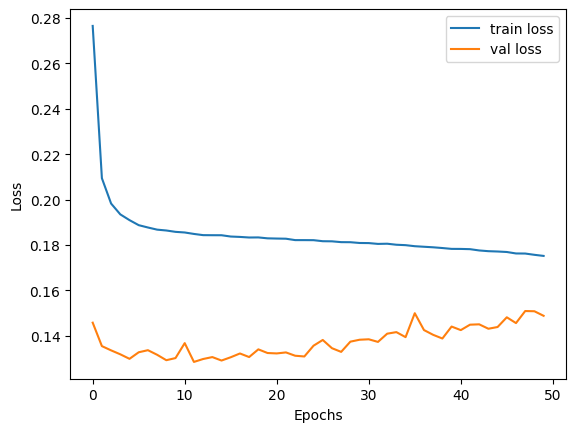

In [101]:
# evaluate
loss_rnn10 = model_rnn10.evaluate(X_test_rnn10, y_test_rnn10.reshape((y_test_rnn10.shape[0], output_steps * len(target))))
print("The loss in testing set: ", loss_rnn10)

plt.plot(history10.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [103]:
# evaluate
y_val_pred_rnn10 = model_rnn10.predict(X_val_rnn10)
y_test_pred_rnn10 = model_rnn10.predict(X_test_rnn10)

print(f'y_test_rnn10 shape: {y_test_rnn10.shape}')
print(f'y_test_pred_rnn10 shape: {y_test_pred_rnn10.shape}')

# Flattening y_test_rnn10 to match the shape of y_test_pred_rnn10
# the shape of y_test_rnn10 from (3056, 3, 2) to (3056, 6)
y_test_rnn10_flat = y_test_rnn10.reshape(3056, -1)

# make sure y_test_rnn10_flat and y_test_pred_rnn10 have same shape
assert y_test_rnn10_flat.shape == y_test_pred_rnn10.shape, "Shapes do not match!"

print(f'y_test_rnn10_flat shape: {y_test_rnn10_flat.shape}')

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
y_test_rnn10 shape: (3056, 3, 2)
y_test_pred_rnn10 shape: (3056, 6)
y_test_rnn10_flat shape: (3056, 6)


In [104]:

# MSE
mse_max_rnn10 = mean_squared_error(y_test_rnn10_flat[:, 0], y_test_pred_rnn10[:, 0])
mse_min_rnn10 = mean_squared_error(y_test_rnn10_flat[:, 1].flatten(), y_test_pred_rnn10[:, 1].flatten())

# MAE
mae_max_rnn10 = mean_absolute_error(y_test_rnn10_flat[:, 0].flatten(), y_test_pred_rnn10[:, 0].flatten())
mae_min_rnn10 = mean_absolute_error(y_test_rnn10_flat[:, 1].flatten(), y_test_pred_rnn10[:, 1].flatten())

# R²
r2_max_rnn10 = r2_score(y_test_rnn10_flat[:, 0].flatten(), y_test_pred_rnn10[:, 0].flatten())
r2_min_rnn10 = r2_score(y_test_rnn10_flat[:, 1].flatten(), y_test_pred_rnn10[:, 1].flatten())

# RMSE
rmse_max_rnn10 = np.sqrt(mse_max_rnn10)
rmse_min_rnn10 = np.sqrt(mse_min_rnn10)



print(f"RMSE of 'max_temp' in test set: {rmse_max_rnn10}")
print(f"RMSE of 'min_temp' in test set: {rmse_min_rnn10}")

print(f"MSE of 'max_temp' in test set: {mse_max_rnn10}")
print(f"MSE of 'min_temp' in test set: {mse_min_rnn10}")

print(f"MAE of 'max_temp' in test set: {mae_max_rnn10}")
print(f"MAE of 'min_temp' in test set: {mae_min_rnn10}")

print(f"R² of 'max_temp' in test set: {r2_max_rnn10}")
print(f"R² of 'min_temp' in test set: {r2_min_rnn10}")

RMSE of 'max_temp' in test set: 0.40297232113327
RMSE of 'min_temp' in test set: 0.3887022280456923
MSE of 'max_temp' in test set: 0.16238669159953525
MSE of 'min_temp' in test set: 0.1510894220876854
MAE of 'max_temp' in test set: 0.30529344984909623
MAE of 'min_temp' in test set: 0.31001912385337244
R² of 'max_temp' in test set: 0.8359384549668885
R² of 'min_temp' in test set: 0.8402762425696243


In [106]:
# Permutation Feature Importance
from sklearn.inspection import permutation_importance

X_test_rnn10_reshaped = X_test_rnn10.reshape(X_test_rnn10.shape[0], -1)

def custom_scoring(estimator, X, y):
    X_reshaped = X.reshape(-1, input_steps, len(features))
    y_pred = estimator.predict(X_reshaped)
    return -np.mean((y_pred - y) ** 2)

# scikit-learn  permutation_importance
result_rnn10 = permutation_importance(estimator=model_rnn10, X=X_test_rnn10_reshaped, y=y_test_rnn10.reshape((y_test_rnn10.shape[0], output_steps * len(target))), n_repeats=10, random_state=42, scoring=custom_scoring, n_jobs=-1)

for i in range(len(features)):
    print(f"Feature: {features[i]}, Importance: {result_rnn10.importances_mean[i]}")


96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NU

96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step 
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
96/96 ━━━━━━━━━

In [59]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam

# Create a time window function
def create_time_series10(X, y, input_steps=10, output_steps=3):
    Xs, ys = [], []
    for i in range(len(X) - input_steps - output_steps + 1):
        Xs.append(X[i:(i + input_steps)])
        ys.append(y[(i + input_steps):(i + input_steps + output_steps)])
    return np.array(Xs), np.array(ys)

# create LSTM
def create_lstm_model(input_shape, output_steps, num_targets):
    model = Sequential()
    model.add(LSTM(50, input_shape=input_shape, return_sequences=False))
    model.add(Dense(output_steps * num_targets))  # output_steps * num_targets
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# cross-va
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

input_steps = 10
output_steps = 3

results = {
    'loss': [],
    'rmse_max': [],
    'rmse_min': [],
    'mse_max': [],
    'mse_min': [],
    'mae_max': [],
    'mae_min': [],
    'r2_max': [],
    'r2_min': []
}

# Converts feature and target variables to numpy arrays
X = df_weather[['global_radiation', 'diff_temp', 'mean_temp']].values
y = df_weather[['max_temp', 'min_temp']].values

# Check the shape of y
num_targets = y.shape[1]  

for fold, (train_index, val_index) in enumerate(tscv.split(X)):

    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    X_train_rnn, y_train_rnn = create_time_series10(X_train, y_train, input_steps, output_steps)
    X_val_rnn, y_val_rnn = create_time_series10(X_val, y_val, input_steps, output_steps)
    

    model = create_lstm_model((input_steps, X_train_rnn.shape[2]), output_steps, num_targets)
    history = model.fit(X_train_rnn, y_train_rnn.reshape((y_train_rnn.shape[0], output_steps * num_targets)),
                        epochs=50,
                        batch_size=32,
                        validation_data=(X_val_rnn, y_val_rnn.reshape((y_val_rnn.shape[0], output_steps * num_targets))),
                        verbose=1)
    

    loss = model.evaluate(X_val_rnn, y_val_rnn.reshape((y_val_rnn.shape[0], output_steps * num_targets)), verbose=0)
    y_val_pred_rnn = model.predict(X_val_rnn)

    # Flatters y_val_rnn and y_val_pred_rnn into a 2D array to make sure the shapes match
    y_val_rnn_flat = y_val_rnn.reshape(-1, num_targets)
    y_val_pred_rnn_flat = y_val_pred_rnn.reshape(-1, num_targets)

    mse_max = mean_squared_error(y_val_rnn_flat[:, 0], y_val_pred_rnn_flat[:, 0])
    mse_min = mean_squared_error(y_val_rnn_flat[:, 1], y_val_pred_rnn_flat[:, 1])
    rmse_max = np.sqrt(mse_max)
    rmse_min = np.sqrt(mse_min)
    mae_max = mean_absolute_error(y_val_rnn_flat[:, 0], y_val_pred_rnn_flat[:, 0])
    mae_min = mean_absolute_error(y_val_rnn_flat[:, 1], y_val_pred_rnn_flat[:, 1])
    r2_max = r2_score(y_val_rnn_flat[:, 0], y_val_pred_rnn_flat[:, 0])
    r2_min = r2_score(y_val_rnn_flat[:, 1], y_val_pred_rnn_flat[:, 1])

    results['loss'].append(loss)
    results['rmse_max'].append(rmse_max)
    results['rmse_min'].append(rmse_min)
    results['mse_max'].append(mse_max)
    results['mse_min'].append(mse_min)
    results['mae_max'].append(mae_max)
    results['mae_min'].append(mae_min)
    results['r2_max'].append(r2_max)
    results['r2_min'].append(r2_min)
    print(f'Fold {len(results["loss"])}, Loss: {loss}, RMSE Max: {rmse_max}, RMSE Min: {rmse_min}')

print(f'Average Loss: {np.mean(results["loss"])}')
print(f'Average RMSE of max_temp: {np.mean(results["rmse_max"])}')
print(f'Average RMSE of min_temp: {np.mean(results["rmse_min"])}')
print(f'Average MSE of max_temp: {np.mean(results["mse_max"])}')
print(f'Average MSE of min_temp: {np.mean(results["mse_min"])}')
print(f'Average MAE of max_temp: {np.mean(results["mae_max"])}')
print(f'Average MAE of min_temp: {np.mean(results["mae_min"])}')
print(f'Average R² of max_temp: {np.mean(results["r2_max"])}')
print(f'Average R² of min_temp: {np.mean(results["r2_min"])}')


Epoch 1/50


/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6072 - val_loss: 0.2697
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2781 - val_loss: 0.2378
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2569 - val_loss: 0.2255
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2424 - val_loss: 0.2166
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2261 - val_loss: 0.2109
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2273 - val_loss: 0.2066
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2204 - val_loss: 0.2043
Epoch 8/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2096 - val_loss: 0.2004
Epoch 9/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2070 - val_loss: 0.1981
Epoch 10/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2048 - val_loss: 0.1971
Epoch 11/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2048 - val_loss: 0.1958
Epoch 12/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2089 - val_loss: 0.1954


/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.5493 - val_loss: 0.2666
Epoch 2/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2499 - val_loss: 0.2334
Epoch 3/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2183 - val_loss: 0.2072
Epoch 4/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2074 - val_loss: 0.2004
Epoch 5/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1993 - val_loss: 0.1945
Epoch 6/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1980 - val_loss: 0.1943
Epoch 7/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1952 - val_loss: 0.1917
Epoch 8/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1951 - val_loss: 0.1922
Epoch 9/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1932 - val_loss: 0.1916
Epoch 10/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1934 - val_loss: 0.1915
Epoch 11/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1903 - val_loss: 0.1889
Epoch 12/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.

/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4763 - val_loss: 0.2336
Epoch 2/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2327 - val_loss: 0.2080
Epoch 3/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2133 - val_loss: 0.1969
Epoch 4/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1994 - val_loss: 0.1936
Epoch 5/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1990 - val_loss: 0.1933
Epoch 6/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1919 - val_loss: 0.1917
Epoch 7/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1902 - val_loss: 0.1920
Epoch 8/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1905 - val_loss: 0.1905
Epoch 9/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1892 - val_loss: 0.1909
Epoch 10/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1905 - val_loss: 0.1952
Epoch 11/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1887 - val_loss: 0.1926
Epoch 12/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.

/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


320/320 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4292 - val_loss: 0.2206
Epoch 2/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2147 - val_loss: 0.1984
Epoch 3/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1991 - val_loss: 0.1928
Epoch 4/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1952 - val_loss: 0.1916
Epoch 5/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1933 - val_loss: 0.1922
Epoch 6/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1900 - val_loss: 0.1879
Epoch 7/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1893 - val_loss: 0.1878
Epoch 8/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1912 - val_loss: 0.1875
Epoch 9/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1889 - val_loss: 0.1892
Epoch 10/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1883 - val_loss: 0.1888
Epoch 11/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1900 - val_loss: 0.1879
Epoch 12/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.

/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3901 - val_loss: 0.2318
Epoch 2/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2099 - val_loss: 0.2185
Epoch 3/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1992 - val_loss: 0.2224
Epoch 4/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1923 - val_loss: 0.2136
Epoch 5/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1904 - val_loss: 0.2112
Epoch 6/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1896 - val_loss: 0.2168
Epoch 7/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1909 - val_loss: 0.2115
Epoch 8/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1868 - val_loss: 0.2114
Epoch 9/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1878 - val_loss: 0.2139
Epoch 10/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1906 - val_loss: 0.2114
Epoch 11/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1889 - val_loss: 0.2097
Epoch 12/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.

4.transformer

In [107]:
y_train_rnn101 = y_train_rnn10.reshape((y_train_rnn10.shape[0], output_steps * len(target)))
y_val_rnn101 = y_val_rnn10.reshape((y_val_rnn10.shape[0], output_steps * len(target)))
y_test_rnn101 = y_test_rnn10.reshape((y_test_rnn10.shape[0], output_steps * len(target)))


In [108]:
def build_model2(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
    inputs = Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = Dense(dim, activation="relu")(x)
        x = Dropout(mlp_dropout)(x)
    x = Dense(output_steps * len(target))(x)  # 输出是 6 个神经元，对应 3 天的 max_temp 和 min_temp
    return Model(inputs, x)

In [109]:
from tensorflow.keras.layers import Reshape

input_shape2 = (input_steps, len(features))
model2 = build_model2(
    input_shape2,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

In [110]:
model2.compile(
    loss="mean_squared_error",
    optimizer=Adam(learning_rate=1e-4),
)

model2.summary()


Model: "functional_57"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_34      │ (None, 10, 3)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 3)     │          6 │ input_layer_34[0… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 3)     │     15,363 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_144         │ (None, 10, 3)     │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_88 (Add)        │ (None, 10, 3)     │          0 │ dropout_144[0][0… │
│                     │                   │            │ input_layer_34[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 3)     │          6 │ add_88[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_133 (Dense)   │ (None, 10, 4)     │         16 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_145         │ (None, 10, 4)     │          0 │ dense_133[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_134 (Dense)   │ (None, 10, 3)     │         15 │ dropout_145[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_89 (Add)        │ (None, 10, 3)     │          0 │ dense_134[0][0],  │
│                     │                   │            │ add_88[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 3)     │          6 │ add_89[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 3)     │     15,363 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_147         │ (None, 10, 3)     │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_90 (Add)        │ (None, 10, 3)     │          0 │ dropout_147[0][0… │
│                     │                   │            │ add_89[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 3)     │          6 │ add_90[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_135 (Dense)   │ (None, 10, 4)     │         16 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_148         │ (None, 10, 4)     │          0 │ dense_135[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_136 (Dense)   │ (None, 10, 3)     │         15 │ dropout_148[0][0

 Total params: 63,806 (249.24 KB)

 Trainable params: 63,806 (249.24 KB)

 Non-trainable params: 0 (0.00 B)

In [111]:
history2 = model2.fit(
    X_train_rnn10, y_train_rnn101,
    validation_data=(X_val_rnn10, y_val_rnn101),
    epochs=50,
    batch_size=32,
)

model2.save('transformer_weather_model2.h5')

Epoch 1/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - loss: 1.1740 - val_loss: 0.3992
Epoch 2/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.5313 - val_loss: 0.3146
Epoch 3/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 0.4206 - val_loss: 0.2904
Epoch 4/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.3882 - val_loss: 0.2837
Epoch 5/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - loss: 0.3652 - val_loss: 0.2817
Epoch 6/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - loss: 0.3472 - val_loss: 0.2644
Epoch 7/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.3340 - val_loss: 0.2620
Epoch 8/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - loss: 0.3251 - val_loss: 0.2592
Epoch 9/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 0.3187 - val_loss: 0.2556
Epoch 10/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - loss: 0.3119 - val_loss: 0.2492
Epoch 11/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.3073 - val_loss: 0.2446
Epoch 12/50
288/288 ━━━━━━━━━━━━━

In [112]:
# evaluate
y_pred_test2 = model2.predict(X_test_rnn10)

# Reshape the predicted and actual results into a flat array to calculate metrics
y_test_actual = y_test_rnn10.reshape(-1, output_steps * len(target))
y_pred_test_flat = y_pred_test2.reshape(-1, output_steps * len(target))



# RMSE
rmse_max_t2 = np.sqrt(mean_squared_error(y_test_actual[:, 0], y_pred_test_flat[:, 0]))
rmse_min_t2 = np.sqrt(mean_squared_error(y_test_actual[:, 1], y_pred_test_flat[:, 1]))

# MSE
mse_max_t2 = mean_squared_error(y_test_actual[:, 0], y_pred_test_flat[:, 0])
mse_min_t2 = mean_squared_error(y_test_actual[:, 1], y_pred_test_flat[:, 1])

# MAE
mae_max_t2 = mean_absolute_error(y_test_actual[:, 0], y_pred_test_flat[:, 0])
mae_min_t2 = mean_absolute_error(y_test_actual[:, 1], y_pred_test_flat[:, 1])

# R²
r2_max_t2 = r2_score(y_test_actual[:, 0], y_pred_test_flat[:, 0])
r2_min_t2 = r2_score(y_test_actual[:, 1], y_pred_test_flat[:, 1])

print(f"RMSE of 'max_temp' in test set: {rmse_max_t2}")
print(f"RMSE of 'min_temp' in test set: {rmse_min_t2}")

print(f"MSE of 'max_temp' in test set: {mse_max_t2}")
print(f"MSE of 'min_temp' in test set: {mse_min_t2}")

print(f"MAE of 'max_temp' in test set: {mae_max_t2}")
print(f"MAE of 'min_temp' in test set: {mae_min_t2}")

print(f"R² of 'max_temp' in test set: {r2_max_t2}")
print(f"R² of 'min_temp' in test set: {r2_min_t2}")

96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
RMSE of 'max_temp' in test set: 0.41213728636805025
RMSE of 'min_temp' in test set: 0.48201765031550925
MSE of 'max_temp' in test set: 0.16985714281482026
MSE of 'min_temp' in test set: 0.23234101521568454
MAE of 'max_temp' in test set: 0.3165091763238219
MAE of 'min_temp' in test set: 0.3904010183093992
R² of 'max_temp' in test set: 0.8283909536513456
R² of 'min_temp' in test set: 0.7543813495169764


In [60]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, LayerNormalization, MultiHeadAttention, Dropout, GlobalAveragePooling1D, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Reshape

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = Add()([x, inputs])

    # Feed Forward Part
    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return Add()([x, res])

# Transformer
def build_model2(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, mlp_dropout=0, dropout=0):
    inputs = Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = Dense(dim, activation="relu")(x)
        x = Dropout(mlp_dropout)(x)
    x = Dense(output_steps * num_targets)(x)  # output_steps * num_targets
    outputs = x
    return Model(inputs, outputs)

# Time window data creation function
def create_time_series10(X, y, input_steps=10, output_steps=3):
    Xs, ys = [], []
    for i in range(len(X) - input_steps - output_steps + 1):
        Xs.append(X[i:(i + input_steps)])
        ys.append(y[(i + input_steps):(i + input_steps + output_steps)])
    return np.array(Xs), np.array(ys)

# Cross validation configuration
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)
results = {
    'loss': [],
    'rmse_max': [],
    'rmse_min': [],
    'mse_max': [],
    'mse_min': [],
    'mae_max': [],
    'mae_min': [],
    'r2_max': [],
    'r2_min': []
}

input_steps = 10
output_steps = 3

X = df_weather[['global_radiation', 'diff_temp', 'mean_temp']].values
y = df_weather[['max_temp', 'min_temp']].values

num_features = X.shape[1]
num_targets = y.shape[1]

for fold, (train_index, val_index) in enumerate(tscv.split(X)):

    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    

    X_train_rnn10, y_train_rnn10 = create_time_series10(X_train, y_train, input_steps, output_steps)
    X_val_rnn10, y_val_rnn10 = create_time_series10(X_val, y_val, input_steps, output_steps)

    y_train_rnn101 = y_train_rnn10.reshape((y_train_rnn10.shape[0], output_steps * num_targets))
    y_val_rnn101 = y_val_rnn10.reshape((y_val_rnn10.shape[0], output_steps * num_targets))
    

    model2 = build_model2(
        (input_steps, num_features),
        head_size=256,
        num_heads=4,
        ff_dim=4,
        num_transformer_blocks=4,
        mlp_units=[128],
        mlp_dropout=0.4,
        dropout=0.25,
    )

    model2.compile(loss="mean_squared_error", optimizer=Adam(learning_rate=1e-4))
    model2.fit(X_train_rnn10, y_train_rnn101,
               validation_data=(X_val_rnn10, y_val_rnn101),
               epochs=50,
               batch_size=32,
               verbose=1)

    val_loss = model2.evaluate(X_val_rnn10, y_val_rnn101, verbose=0)
    y_val_pred = model2.predict(X_val_rnn10)
    
    y_val_rnn_flat = y_val_rnn10.reshape(-1, num_targets)
    y_val_pred_flat = y_val_pred.reshape(-1, num_targets)
    
    mse_max = mean_squared_error(y_val_rnn_flat[:, 0], y_val_pred_flat[:, 0])
    mse_min = mean_squared_error(y_val_rnn_flat[:, 1], y_val_pred_flat[:, 1])
    rmse_max = np.sqrt(mse_max)
    rmse_min = np.sqrt(mse_min)
    mae_max = mean_absolute_error(y_val_rnn_flat[:, 0], y_val_pred_flat[:, 0])
    mae_min = mean_absolute_error(y_val_rnn_flat[:, 1], y_val_pred_flat[:, 1])
    r2_max = r2_score(y_val_rnn_flat[:, 0], y_val_pred_flat[:, 0])
    r2_min = r2_score(y_val_rnn_flat[:, 1], y_val_pred_flat[:, 1])
    
    results['loss'].append(val_loss)
    results['rmse_max'].append(rmse_max)
    results['rmse_min'].append(rmse_min)
    results['mse_max'].append(mse_max)
    results['mse_min'].append(mse_min)
    results['mae_max'].append(mae_max)
    results['mae_min'].append(mae_min)
    results['r2_max'].append(r2_max)
    results['r2_min'].append(r2_min)
    
    print(f'Fold {fold + 1}, Loss: {val_loss}, RMSE Max: {rmse_max}, RMSE Min: {rmse_min}')


print(f'Average Loss: {np.mean(results["loss"])}')
print(f'Average RMSE of max_temp: {np.mean(results["rmse_max"])}')
print(f'Average RMSE of min_temp: {np.mean(results["rmse_min"])}')
print(f'Average MSE of max_temp: {np.mean(results["mse_max"])}')
print(f'Average MSE of min_temp: {np.mean(results["mse_min"])}')
print(f'Average MAE of max_temp: {np.mean(results["mae_max"])}')
print(f'Average MAE of min_temp: {np.mean(results["mae_min"])}')
print(f'Average R² of max_temp: {np.mean(results["r2_max"])}')
print(f'Average R² of min_temp: {np.mean(results["r2_min"])}')


Epoch 1/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 1.5790 - val_loss: 0.8096
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.9262 - val_loss: 0.5394
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.7372 - val_loss: 0.4287
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.6308 - val_loss: 0.3777
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.5638 - val_loss: 0.3487
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.5335 - val_loss: 0.3293
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.5081 - val_loss: 0.3226
Epoch 8/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.4867 - val_loss: 0.3124
Epoch 9/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.4560 - val_loss: 0.3038
Epoch 10/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.4613 - val_loss: 0.3016
Epoch 11/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.4474 - val_loss: 0.2978
Epoch 12/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.4

<center>
    Ⅲ.Based on the weather of the past thirty days, predict the highest and lowest temperatures for the thirty-first  day
</center>

1.Baseline model - Moving average


In [113]:

window_size30 = 30

X = df_weather[['date', 'global_radiation','diff_temp','mean_temp']]  # 特征
y = df_weather[['max_temp', 'min_temp']]       # 目标变量

X_train_val, X_test, y_train_val, y_test = split_data(X, y, test_size=0.2)

X_train, X_val, y_train, y_val = split_data(X_train_val, y_train_val, test_size=0.25)

X_train_ma30 = np.zeros((X_train.shape[0] - window_size30 + 1, X_train.shape[1]))
for i in range(X_train.shape[1]):
    X_train_ma30[:, i] = moving_average(X_train.iloc[:, i], window_size30)

y_train_max_ma30 = moving_average(y_train['max_temp'].values, window_size30)
y_train_min_ma30 = moving_average(y_train['min_temp'].values, window_size30)

In [114]:
# create and train
model_max_temp30 = MovingAverageModel()
model_min_temp30 = MovingAverageModel()
model_max_temp30.fit(X_train_ma30, y_train_max_ma30)
model_min_temp30.fit(X_train_ma30, y_train_min_ma30)

# evaluate in val
X_val_ma30 = np.zeros((X_val.shape[0] - window_size30 + 1, X_val.shape[1]))
for i in range(X_val.shape[1]):
    X_val_ma30[:, i] = moving_average(X_val.iloc[:, i], window_size30)

y_val_pred_max30 = model_max_temp30.predict(X_val_ma30)
y_val_pred_min30 = model_min_temp30.predict(X_val_ma30)

# pred in test
X_test_ma30 = np.zeros((X_test.shape[0] - window_size30 + 1, X_test.shape[1]))
for i in range(X_test.shape[1]):
    X_test_ma30[:, i] = moving_average(X_test.iloc[:, i], window_size30)

y_test_pred_max_ma30 = model_max_temp30.predict(X_test_ma30)
y_test_pred_min_ma30 = model_min_temp30.predict(X_test_ma30)

In [115]:
# 评evaluate

# RMSE
mse_max_ma30 = mean_squared_error(y_test['max_temp'].values[window_size30 - 1:], y_test_pred_max_ma30)
mse_min_ma30 = mean_squared_error(y_test['min_temp'].values[window_size30 - 1:], y_test_pred_min_ma30)

# MSE
mse_max_ma30 = mean_squared_error(y_test['max_temp'].values[window_size30 - 1:], y_test_pred_max_ma30)
mse_min_ma30 = mean_squared_error(y_test['min_temp'].values[window_size30 - 1:], y_test_pred_min_ma30)

# MAE
mae_max_ma30 = mean_absolute_error(y_test['max_temp'].values[window_size30 - 1:], y_test_pred_max_ma30)
mae_min_ma30 = mean_absolute_error(y_test['min_temp'].values[window_size30 - 1:], y_test_pred_min_ma30)

# R2
r2_max_ma30 = r2_score(y_test['max_temp'].values[window_size30 - 1:], y_test_pred_max_ma30)
r2_min_ma30 = r2_score(y_test['min_temp'].values[window_size30 - 1:], y_test_pred_min_ma30)

print("RMSE of 'max_temp' in test set: {:.2f}".format(np.sqrt(mse_max_ma30)))
print("RMSE of 'min_temp' in test set: {:.2f}".format(np.sqrt(mse_min_ma30)))

print("MSE of 'max_temp' in test set: {:.2f}".format(mse_max_ma30))
print("MSE of 'min_temp' in test set: {:.2f}".format(mse_min_ma30))

print("MAE of 'max_temp' in test set: {:.2f}".format(mae_max_ma30))
print("MAE of 'min_temp' in test set: {:.2f}".format(mae_min_ma30))

print("R² of 'max_temp' in test set: {:.2f}".format(r2_max_ma30))
print("R² of 'min_temp' in test set: {:.2f}".format(r2_min_ma30))

RMSE of 'max_temp' in test set: 0.53
RMSE of 'min_temp' in test set: 0.59
MSE of 'max_temp' in test set: 0.28
MSE of 'min_temp' in test set: 0.34
MAE of 'max_temp' in test set: 0.42
MAE of 'min_temp' in test set: 0.47
R² of 'max_temp' in test set: 0.71
R² of 'min_temp' in test set: 0.64


In [140]:
## cross-val

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

tscv = TimeSeriesSplit(n_splits=5)
window_size = 30

mse_scores_max = []
mse_scores_min = []
rmse_scores_max = []
rmse_scores_min = []
mae_scores_max = []
mae_scores_min = []
r2_scores_max = []
r2_scores_min = []

X_train = X_train.to_numpy()
y_train = y_train.to_numpy()


for train_index, val_index in tscv.split(X_train):

    X_train_cv, X_val_cv = X_train[train_index], X_train[val_index]
    y_train_max_cv, y_val_max_cv = y_train[train_index, 0], y_train[val_index, 0]
    y_train_min_cv, y_val_min_cv = y_train[train_index, 1], y_train[val_index, 1]
    

    X_train_ma = np.zeros((X_train_cv.shape[0] - window_size + 1, X_train_cv.shape[1]))
    X_val_ma = np.zeros((X_val_cv.shape[0] - window_size + 1, X_val_cv.shape[1]))
    for i in range(X_train_cv.shape[1]):
        X_train_ma[:, i] = moving_average(X_train_cv[:, i], window_size)
        X_val_ma[:, i] = moving_average(X_val_cv[:, i], window_size)
    
    y_train_max_ma = moving_average(y_train_max_cv, window_size)
    y_train_min_ma = moving_average(y_train_min_cv, window_size)
    
    # Create the corresponding moving average for the validation set label
    y_val_max_ma = moving_average(y_val_max_cv, window_size)
    y_val_min_ma = moving_average(y_val_min_cv, window_size)
    
    model_max_temp = MovingAverageModel()
    model_min_temp = MovingAverageModel()
    model_max_temp.fit(X_train_ma, y_train_max_ma)
    model_min_temp.fit(X_train_ma, y_train_min_ma)
    

    y_val_pred_max = model_max_temp.predict(X_val_ma)
    y_val_pred_min = model_min_temp.predict(X_val_ma)
    

    mse_max = mean_squared_error(y_val_max_ma, y_val_pred_max)
    mse_min = mean_squared_error(y_val_min_ma, y_val_pred_min)
    rmse_max = np.sqrt(mse_max)
    rmse_min = np.sqrt(mse_min)
    mae_max = mean_absolute_error(y_val_max_ma, y_val_pred_max)
    mae_min = mean_absolute_error(y_val_min_ma, y_val_pred_min)
    r2_max = r2_score(y_val_max_ma, y_val_pred_max)
    r2_min = r2_score(y_val_min_ma, y_val_pred_min)
    
    mse_scores_max.append(mse_max)
    mse_scores_min.append(mse_min)
    rmse_scores_max.append(rmse_max)
    rmse_scores_min.append(rmse_min)
    mae_scores_max.append(mae_max)
    mae_scores_min.append(mae_min)
    r2_scores_max.append(r2_max)
    r2_scores_min.append(r2_min)


print("Cross-validation results:")
print(f"Average MSE of 'max_temp': {np.mean(mse_scores_max):.2f}")
print(f"Average MSE of 'min_temp': {np.mean(mse_scores_min):.2f}")
print(f"Average RMSE of 'max_temp': {np.mean(rmse_scores_max):.2f}")
print(f"Average RMSE of 'min_temp': {np.mean(rmse_scores_min):.2f}")
print(f"Average MAE of 'max_temp': {np.mean(mae_scores_max):.2f}")
print(f"Average MAE of 'min_temp': {np.mean(mae_scores_min):.2f}")
print(f"Average R² of 'max_temp': {np.mean(r2_scores_max):.2f}")
print(f"Average R² of 'min_temp': {np.mean(r2_scores_min):.2f}")


Cross-validation results:
Average MSE of 'max_temp': 0.00
Average MSE of 'min_temp': 0.00
Average RMSE of 'max_temp': 0.03
Average RMSE of 'min_temp': 0.03
Average MAE of 'max_temp': 0.02
Average MAE of 'min_temp': 0.03
Average R² of 'max_temp': 0.97
Average R² of 'min_temp': 0.97


2.Random forest

In [116]:
def create_features_and_target30(df, n_days=30):
    df = df.copy()
    for i in range(1, n_days + 1):
        df[f'global_radiation_{i}d'] = df['global_radiation'].shift(i)
        df[f'diff_temp_{i}d'] = df['diff_temp'].shift(i)
        df[f'mean_temp_{i}d'] = df['mean_temp'].shift(i)
    
    df = df.dropna().reset_index(drop=True)
    X30 = df[[f'global_radiation_{i}d' for i in range(1, n_days + 1)] +
           [f'diff_temp_{i}d' for i in range(1, n_days + 1)] +
           [f'mean_temp_{i}d' for i in range(1, n_days + 1)]]
    y_max_rf30 = df['max_temp']
    y_min_rf30 = df['min_temp']
    return X30, y_max_rf30, y_min_rf30

X_train_rf30, y_train_max_rf30, y_train_min_rf30 = create_features_and_target30(train_df_weather)
X_val_rf30, y_val_max_rf30, y_val_min_rf30 = create_features_and_target30(val_df_weather)
X_test_rf30, y_test_max_rf30, y_test_min_rf30 = create_features_and_target30(test_df_weather)

In [117]:
# create and train
rf_max30 = RandomForestRegressor(n_estimators=100, random_state=42)
rf_max30.fit(X_train_rf30, y_train_max_rf30)

rf_min30 = RandomForestRegressor(n_estimators=100, random_state=42)
rf_min30.fit(X_train_rf30, y_train_min_rf30)

y_val_pred_max_rf30 = rf_max30.predict(X_val_rf30)
y_val_pred_min_rf30 = rf_min30.predict(X_val_rf30)

y_test_pred_max_rf30 = rf_max30.predict(X_test_rf30)
y_test_pred_min_rf30 = rf_min30.predict(X_test_rf30)

In [118]:
# evaluate

# RMSE)
rmse_max_rf30 = np.sqrt(mean_squared_error(y_test_max_rf30, y_test_pred_max_rf30))
rmse_min_rf30 = np.sqrt(mean_squared_error(y_test_min_rf30, y_test_pred_min_rf30))

# MSE
mse_max_rf30 = mean_squared_error(y_test_max_rf30, y_test_pred_max_rf30)
mse_min_rf30 = mean_squared_error(y_test_min_rf30, y_test_pred_min_rf30)

# MAE
mae_max_rf30 = mean_absolute_error(y_test_max_rf30, y_test_pred_max_rf30)
mae_min_rf30 = mean_absolute_error(y_test_min_rf30, y_test_pred_min_rf30)

# R²
r2_max_rf30 = r2_score(y_test_max_rf30, y_test_pred_max_rf30)
r2_min_rf30 = r2_score(y_test_min_rf30, y_test_pred_min_rf30)

print(f"RMSE of 'max_temp' in test set: {rmse_max_rf30}")
print(f"RMSE of 'min_temp' in test set: {rmse_min_rf30}")

print(f"MSE of 'max_temp' in test set: {mse_max_rf30}")
print(f"MSE of 'min_temp' in test set: {mse_min_rf30}")

print(f"MAE of 'max_temp' in test set: {mae_max_rf30}")
print(f"MAE of 'min_temp' in test set: {mae_min_rf30}")

print(f"R² of 'max_temp' in test set: {r2_max_rf30}")
print(f"R² of 'min_temp' in test set: {r2_min_rf30}")

RMSE of 'max_temp' in test set: 0.4036425938153924
RMSE of 'min_temp' in test set: 0.39299474804080636
MSE of 'max_temp' in test set: 0.16292734354201788
MSE of 'min_temp' in test set: 0.15444487198765686
MAE of 'max_temp' in test set: 0.3101061335994656
MAE of 'min_temp' in test set: 0.31663187447449526
R² of 'max_temp' in test set: 0.8354561484255199
R² of 'min_temp' in test set: 0.8366807075635517


In [144]:
# cross-val

import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


X, y_max, y_min = create_features_and_target30(df_weather)
tscv = TimeSeriesSplit(n_splits=5)

mse_scores_max = []
mse_scores_min = []
rmse_scores_max = []
rmse_scores_min = []
mae_scores_max = []
mae_scores_min = []
r2_scores_max = []
r2_scores_min = []


for train_index, val_index in tscv.split(X):

    X_train_cv, X_val_cv = X.iloc[train_index], X.iloc[val_index]
    y_train_max_cv, y_val_max_cv = y_max[train_index], y_max[val_index]
    y_train_min_cv, y_val_min_cv = y_min[train_index], y_min[val_index]
    

    rf_max = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_max.fit(X_train_cv, y_train_max_cv)
    
    rf_min = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_min.fit(X_train_cv, y_train_min_cv)
    
    y_val_pred_max_rf = rf_max.predict(X_val_cv)
    y_val_pred_min_rf = rf_min.predict(X_val_cv)
    
    mse_max = mean_squared_error(y_val_max_cv, y_val_pred_max_rf)
    mse_min = mean_squared_error(y_val_min_cv, y_val_pred_min_rf)
    rmse_max = np.sqrt(mse_max)
    rmse_min = np.sqrt(mse_min)
    mae_max = mean_absolute_error(y_val_max_cv, y_val_pred_max_rf)
    mae_min = mean_absolute_error(y_val_min_cv, y_val_pred_min_rf)
    r2_max = r2_score(y_val_max_cv, y_val_pred_max_rf)
    r2_min = r2_score(y_val_min_cv, y_val_pred_min_rf)
    
    mse_scores_max.append(mse_max)
    mse_scores_min.append(mse_min)
    rmse_scores_max.append(rmse_max)
    rmse_scores_min.append(rmse_min)
    mae_scores_max.append(mae_max)
    mae_scores_min.append(mae_min)
    r2_scores_max.append(r2_max)
    r2_scores_min.append(r2_min)


print("Cross-validation results:")
print(f"Average MSE of 'max_temp': {np.mean(mse_scores_max):.2f}")
print(f"Average MSE of 'min_temp': {np.mean(mse_scores_min):.2f}")
print(f"Average RMSE of 'max_temp': {np.mean(rmse_scores_max):.2f}")
print(f"Average RMSE of 'min_temp': {np.mean(rmse_scores_min):.2f}")
print(f"Average MAE of 'max_temp': {np.mean(mae_scores_max):.2f}")
print(f"Average MAE of 'min_temp': {np.mean(mae_scores_min):.2f}")
print(f"Average R² of 'max_temp': {np.mean(r2_scores_max):.2f}")
print(f"Average R² of 'min_temp': {np.mean(r2_scores_min):.2f}")


Cross-validation results:
Average MSE of 'max_temp': 0.15
Average MSE of 'min_temp': 0.14
Average RMSE of 'max_temp': 0.39
Average RMSE of 'min_temp': 0.38
Average MAE of 'max_temp': 0.30
Average MAE of 'min_temp': 0.31
Average R² of 'max_temp': 0.85
Average R² of 'min_temp': 0.85


3.LSTM

In [136]:

def create_time_series30(X, y, time_steps=30):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)


time_steps30 = 30
X_train_rnn30, y_train_rnn30 = create_time_series(train_X_rnn, train_y_rnn, time_steps30)
X_val_rnn30, y_val_rnn30 = create_time_series(val_X_rnn, val_y_rnn, time_steps30)
X_test_rnn30, y_test_rnn30 = create_time_series(test_X_rnn, test_y_rnn, time_steps30)

print("Size of the training set:", X_train_rnn30.shape, y_train_rnn30.shape)
print("Size of the validation set:", X_val_rnn30.shape, y_val_rnn30.shape)
print("Size of the testing set:", X_test_rnn30.shape, y_test_rnn30.shape)


Size of the training set: (9175, 30, 3) (9175, 2)
Size of the validation set: (3038, 30, 3) (3038, 2)
Size of the testing set: (3038, 30, 3) (3038, 2)


In [120]:
# create model
model30 = Sequential()
model30.add(LSTM(50, activation='relu', input_shape=(time_steps30, len(features))))
model30.add(Dense(2))  

model30.compile(optimizer='adam', loss='mse', run_eagerly=True)
model30.summary()

/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_23 (LSTM)                  │ (None, 50)             │        10,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_143 (Dense)               │ (None, 2)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,902 (42.59 KB)

 Trainable params: 10,902 (42.59 KB)

 Non-trainable params: 0 (0.00 B)

In [121]:

history30 = model30.fit(X_train_rnn30, y_train_rnn30, epochs=50, batch_size=32, validation_data=(X_val_rnn30, y_val_rnn30))

Epoch 1/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 20s 71ms/step - loss: 0.3557 - val_loss: 0.1544
Epoch 2/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 20s 71ms/step - loss: 0.1489 - val_loss: 0.1365
Epoch 3/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 20s 71ms/step - loss: 0.1417 - val_loss: 0.1416
Epoch 4/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 20s 71ms/step - loss: 0.1384 - val_loss: 0.1397
Epoch 5/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 20s 71ms/step - loss: 0.1358 - val_loss: 0.1315
Epoch 6/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 20s 71ms/step - loss: 0.1334 - val_loss: 0.1297
Epoch 7/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 20s 71ms/step - loss: 0.1334 - val_loss: 0.1379
Epoch 8/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 20s 71ms/step - loss: 0.1335 - val_loss: 0.1368
Epoch 9/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 22s 75ms/step - loss: 0.1322 - val_loss: 0.1305
Epoch 10/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 20s 71ms/step - loss: 0.1312 - val_loss: 0.1294
Epoch 11/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 20s 71ms/step - loss: 0.1296 - val_loss: 0.1338
Epoch 12/50
287/287 ━━━━━━━━━━

In [122]:

model30.save('rnn_weather_model30.h5')

95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.1368
The loss in testing set: 0.16712136566638947


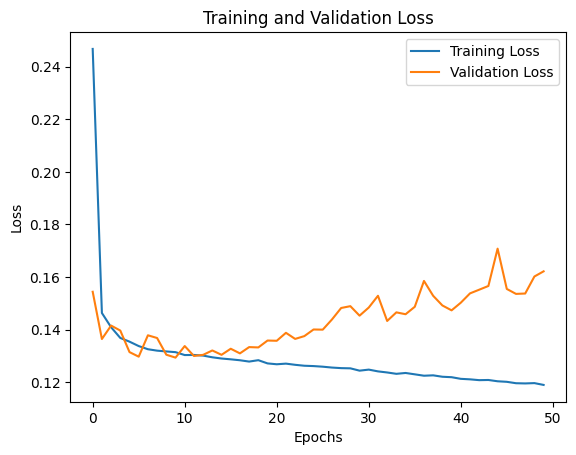

In [123]:
# 评evaluate
loss30 = model30.evaluate(X_test_rnn30, y_test_rnn30)
print('The loss in testing set:', loss30)

plt.plot(history30.history['loss'], label='Training Loss')
plt.plot(history30.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [124]:
# evaluate
y_val_pred_rnn30 = model30.predict(X_val_rnn30)

y_test_pred_rnn30 = model30.predict(X_test_rnn30)

# RMSE
rmse_max_rnn30 = np.sqrt(mean_squared_error(y_test_rnn30[:, 0], y_test_pred_rnn30[:, 0]))
rmse_min_rnn30 = np.sqrt(mean_squared_error(y_test_rnn30[:, 1], y_test_pred_rnn30[:, 1]))

# MSE
mse_max_rnn30 = mean_squared_error(y_test_rnn30[:, 0], y_test_pred_rnn30[:, 0])
mse_min_rnn30 = mean_squared_error(y_test_rnn30[:, 1], y_test_pred_rnn30[:, 1])

# MAE
mae_max_rnn30 = mean_absolute_error(y_test_rnn30[:, 0], y_test_pred_rnn30[:, 0])
mae_min_rnn30 = mean_absolute_error(y_test_rnn30[:, 1], y_test_pred_rnn30[:, 1])

# R²
r2_max_rnn30 = r2_score(y_test_rnn30[:, 0], y_test_pred_rnn30[:, 0])
r2_min_rnn30 = r2_score(y_test_rnn30[:, 1], y_test_pred_rnn30[:, 1])

print(f"RMSE of 'max_temp' in test set: {rmse_max_rnn30}")
print(f"RMSE of 'min_temp' in test set: {rmse_min_rnn30}")

print(f"MSE of 'max_temp' in test set: {mse_max_rnn30}")
print(f"MSE of 'min_temp' in test set: {mse_min_rnn30}")

print(f"MAE of 'max_temp' in test set: {mae_max_rnn30}")
print(f"MAE of 'min_temp' in test set: {mae_min_rnn30}")

print(f"R² of 'max_temp' in test set: {r2_max_rnn30}")
print(f"R² of 'min_temp' in test set: {r2_min_rnn30}")


95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step
RMSE of 'max_temp' in test set: 0.4138786075924413
RMSE of 'min_temp' in test set: 0.4036671996773904
MSE of 'max_temp' in test set: 0.17129550182265801
MSE of 'min_temp' in test set: 0.16294720809538615
MAE of 'max_temp' in test set: 0.31527826968793493
MAE of 'min_temp' in test set: 0.31962341491062546
R² of 'max_temp' in test set: 0.8270049642096162
R² of 'min_temp' in test set: 0.827689826226409


In [ ]:
# Permutation Feature Importance

# Flatten data into a two-dimensional array (number of samples, number of time steps * number of features)
X_test_rnn30_reshaped = X_test_rnn30.reshape(X_test_rnn30.shape[0], -1)

def custom_scoring(estimator, X, y):
    X_reshaped30 = X.reshape(-1, time_steps30, len(features))
    y_pred30 = estimator.predict(X_reshaped30)
    return -np.mean((y_pred30 - y) ** 2)

# scikit-learn permutation_importance
result_rnn30 = permutation_importance(estimator=model, X=X_test_rnn30_reshaped, y=y_test_rnn30, n_repeats=10, random_state=42, scoring=custom_scoring, n_jobs=-1)

for i in range(len(features)):
    print(f"Feature: {features[i]}, Importance: {result_rnn30.importances_mean[i]}")


95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NU

KeyboardInterrupt: 

In [62]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam

def create_time_series(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)


def create_lstm_model(input_shape, num_targets):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=input_shape, return_sequences=False))
    model.add(Dense(num_targets))  
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# cross-val
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

time_steps = 30
num_targets = 2  



results = {
    'val_loss': [],
    'rmse_max': [],
    'rmse_min': [],
    'mse_max': [],
    'mse_min': [],
    'mae_max': [],
    'mae_min': [],
    'r2_max': [],
    'r2_min': []
}

# Converts feature and target variables to numpy arrays
X = df_weather[['global_radiation', 'diff_temp', 'mean_temp']].values
y = df_weather[['max_temp', 'min_temp']].values

for fold, (train_index, val_index) in enumerate(tscv.split(X)):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]


    X_train_rnn, y_train_rnn = create_time_series(X_train, y_train, time_steps)
    X_val_rnn, y_val_rnn = create_time_series(X_val, y_val, time_steps)

    model = create_lstm_model((time_steps, X_train_rnn.shape[2]), num_targets)
    history = model.fit(X_train_rnn, y_train_rnn, epochs=50, batch_size=32, validation_data=(X_val_rnn, y_val_rnn), verbose=1)

    val_loss = model.evaluate(X_val_rnn, y_val_rnn, verbose=0)
    y_val_pred = model.predict(X_val_rnn)

    assert y_val_rnn.shape[0] == y_val_pred.shape[0], "预测值和实际值的长度不一致！"

    mse_max = mean_squared_error(y_val_rnn[:, 0], y_val_pred[:, 0])
    mse_min = mean_squared_error(y_val_rnn[:, 1], y_val_pred[:, 1])
    rmse_max = np.sqrt(mse_max)
    rmse_min = np.sqrt(mse_min)
    mae_max = mean_absolute_error(y_val_rnn[:, 0], y_val_pred[:, 0])
    mae_min = mean_absolute_error(y_val_rnn[:, 1], y_val_pred[:, 1])
    r2_max = r2_score(y_val_rnn[:, 0], y_val_pred[:, 0])
    r2_min = r2_score(y_val_rnn[:, 1], y_val_pred[:, 1])

    results['val_loss'].append(val_loss)
    results['rmse_max'].append(rmse_max)
    results['rmse_min'].append(rmse_min)
    results['mse_max'].append(mse_max)
    results['mse_min'].append(mse_min)
    results['mae_max'].append(mae_max)
    results['mae_min'].append(mae_min)
    results['r2_max'].append(r2_max)
    results['r2_min'].append(r2_min)
    
    print(f'Fold {fold + 1}, Validation Loss: {val_loss}, RMSE Max: {rmse_max}, RMSE Min: {rmse_min}')

print(f'Average Validation Loss: {np.mean(results["val_loss"])}')
print(f'Average RMSE of max_temp: {np.mean(results["rmse_max"])}')
print(f'Average RMSE of min_temp: {np.mean(results["rmse_min"])}')
print(f'Average MSE of max_temp: {np.mean(results["mse_max"])}')
print(f'Average MSE of min_temp: {np.mean(results["mse_min"])}')
print(f'Average MAE of max_temp: {np.mean(results["mae_max"])}')
print(f'Average MAE of min_temp: {np.mean(results["mae_min"])}')
print(f'Average R² of max_temp: {np.mean(results["r2_max"])}')
print(f'Average R² of min_temp: {np.mean(results["r2_min"])}')

Epoch 1/50


/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.6586 - val_loss: 0.2615
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2652 - val_loss: 0.2032
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2012 - val_loss: 0.1826
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1757 - val_loss: 0.1529
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1598 - val_loss: 0.1425
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1554 - val_loss: 0.1524
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1489 - val_loss: 0.1412
Epoch 8/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1427 - val_loss: 0.1405
Epoch 9/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1451 - val_loss: 0.1406
Epoch 10/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1401 - val_loss: 0.1388
Epoch 11/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1405 - val_loss: 0.1423
Epoch 12/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1411 - val_loss: 0.1370

/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.5385 - val_loss: 0.2035
Epoch 2/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1864 - val_loss: 0.1476
Epoch 3/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1522 - val_loss: 0.1393
Epoch 4/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1472 - val_loss: 0.1341
Epoch 5/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1420 - val_loss: 0.1443
Epoch 6/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1431 - val_loss: 0.1327
Epoch 7/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1376 - val_loss: 0.1381
Epoch 8/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1400 - val_loss: 0.1376
Epoch 9/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1348 - val_loss: 0.1323
Epoch 10/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1363 - val_loss: 0.1353
Epoch 11/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1348 - val_loss: 0.1297
Epoch 12/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.

/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3914 - val_loss: 0.1918
Epoch 2/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1710 - val_loss: 0.1521
Epoch 3/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1476 - val_loss: 0.1362
Epoch 4/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1396 - val_loss: 0.1336
Epoch 5/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1369 - val_loss: 0.1328
Epoch 6/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1400 - val_loss: 0.1335
Epoch 7/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1380 - val_loss: 0.1328
Epoch 8/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1325 - val_loss: 0.1294
Epoch 9/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1352 - val_loss: 0.1304
Epoch 10/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1317 - val_loss: 0.1279
Epoch 11/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1317 - val_loss: 0.1352
Epoch 12/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.

/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.4335 - val_loss: 0.1477
Epoch 2/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1512 - val_loss: 0.1327
Epoch 3/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1410 - val_loss: 0.1330
Epoch 4/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1371 - val_loss: 0.1284
Epoch 5/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1347 - val_loss: 0.1335
Epoch 6/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1373 - val_loss: 0.1284
Epoch 7/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1340 - val_loss: 0.1276
Epoch 8/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1317 - val_loss: 0.1277
Epoch 9/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1320 - val_loss: 0.1280
Epoch 10/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1322 - val_loss: 0.1271
Epoch 11/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1312 - val_loss: 0.1305
Epoch 12/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.

/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


399/399 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.2864 - val_loss: 0.1739
Epoch 2/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1430 - val_loss: 0.1602
Epoch 3/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1366 - val_loss: 0.1703
Epoch 4/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1351 - val_loss: 0.1596
Epoch 5/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1319 - val_loss: 0.1558
Epoch 6/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1318 - val_loss: 0.1607
Epoch 7/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1311 - val_loss: 0.1606
Epoch 8/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1300 - val_loss: 0.1598
Epoch 9/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1259 - val_loss: 0.1592
Epoch 10/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1313 - val_loss: 0.1592
Epoch 11/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1287 - val_loss: 0.1653
Epoch 12/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.

4.transformer

In [152]:
input_shape3 = (time_steps30, len(features))
model3 = build_model(
    input_shape3,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

In [153]:
model3.compile(
    loss="mean_squared_error",
    optimizer=Adam(learning_rate=1e-4),
)

model3.summary()

Model: "functional_76"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_46      │ (None, 30, 3)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 3)     │          6 │ input_layer_46[0… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 3)     │     15,363 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_209         │ (None, 30, 3)     │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_128 (Add)       │ (None, 30, 3)     │          0 │ dropout_209[0][0… │
│                     │                   │            │ input_layer_46[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 3)     │          6 │ add_128[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_190 (Dense)   │ (None, 30, 4)     │         16 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_210         │ (None, 30, 4)     │          0 │ dense_190[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_191 (Dense)   │ (None, 30, 3)     │         15 │ dropout_210[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_129 (Add)       │ (None, 30, 3)     │          0 │ dense_191[0][0],  │
│                     │                   │            │ add_128[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 3)     │          6 │ add_129[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 3)     │     15,363 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_212         │ (None, 30, 3)     │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_130 (Add)       │ (None, 30, 3)     │          0 │ dropout_212[0][0… │
│                     │                   │            │ add_129[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 3)     │          6 │ add_130[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_192 (Dense)   │ (None, 30, 4)     │         16 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_213         │ (None, 30, 4)     │          0 │ dense_192[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_193 (Dense)   │ (None, 30, 3)     │         15 │ dropout_213[0][0

 Total params: 65,850 (257.23 KB)

 Trainable params: 65,850 (257.23 KB)

 Non-trainable params: 0 (0.00 B)

In [154]:
history3 = model3.fit(
    X_train_rnn30, y_train_rnn30,
    validation_data=(X_val_rnn30, y_val_rnn30),
    epochs=50,
    batch_size=32,
)

model3.save('transformer_weather_model30.h5')

Epoch 1/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 35s 100ms/step - loss: 1.5408 - val_loss: 0.2963
Epoch 2/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 28s 97ms/step - loss: 0.5929 - val_loss: 0.2717
Epoch 3/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 28s 97ms/step - loss: 0.4962 - val_loss: 0.2600
Epoch 4/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 28s 98ms/step - loss: 0.4403 - val_loss: 0.2560
Epoch 5/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 28s 99ms/step - loss: 0.3989 - val_loss: 0.2380
Epoch 6/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 28s 98ms/step - loss: 0.3659 - val_loss: 0.2366
Epoch 7/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 28s 98ms/step - loss: 0.3460 - val_loss: 0.2221
Epoch 8/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 28s 98ms/step - loss: 0.3326 - val_loss: 0.2169
Epoch 9/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 28s 98ms/step - loss: 0.3070 - val_loss: 0.2193
Epoch 10/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 28s 99ms/step - loss: 0.2980 - val_loss: 0.2109
Epoch 11/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 29s 100ms/step - loss: 0.2850 - val_loss: 0.2048
Epoch 12/50
287/287 ━━━━━━━━

In [155]:
# evaluate
y_val_pred_t30 = model3.predict(X_val_rnn30)
y_test_pred_t30 = model3.predict(X_test_rnn30)

# RMSE
rmse_max_t30 = np.sqrt(mean_squared_error(y_test_rnn30[:, 0], y_test_pred_rnn30[:, 0]))
rmse_min_t30 = np.sqrt(mean_squared_error(y_test_rnn30[:, 1], y_test_pred_rnn30[:, 1]))

# MSE
mse_max_t30 = mean_squared_error(y_test_rnn30[:, 0], y_test_pred_rnn30[:, 0])
mse_min_t30 = mean_squared_error(y_test_rnn30[:, 1], y_test_pred_rnn30[:, 1])

# MAE
mae_max_t30 = mean_absolute_error(y_test_rnn30[:, 0], y_test_pred_rnn30[:, 0])
mae_min_t30 = mean_absolute_error(y_test_rnn30[:, 1], y_test_pred_rnn30[:, 1])

# R²
r2_max_t30 = r2_score(y_test_rnn30[:, 0], y_test_pred_rnn30[:, 0])
r2_min_t30 = r2_score(y_test_rnn30[:, 1], y_test_pred_rnn30[:, 1])

print(f"RMSE of 'max_temp' in test set: {rmse_max_t30}")
print(f"RMSE of 'min_temp' in test set: {rmse_min_t30}")

print(f"MSE of 'max_temp' in test set: {mse_max_t30}")
print(f"MSE of 'min_temp' in test set: {mse_min_t30}")

print(f"MAE of 'max_temp' in test set: {mae_max_t30}")
print(f"MAE of 'min_temp' in test set: {mae_min_t30}")

print(f"R² of 'max_temp' in test set: {r2_max_t30}")
print(f"R² of 'min_temp' in test set: {r2_min_t30}")

95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step
RMSE of 'max_temp' in test set: 0.4138786075924413
RMSE of 'min_temp' in test set: 0.4036671996773904
MSE of 'max_temp' in test set: 0.17129550182265801
MSE of 'min_temp' in test set: 0.16294720809538615
MAE of 'max_temp' in test set: 0.31527826968793493
MAE of 'min_temp' in test set: 0.31962341491062546
R² of 'max_temp' in test set: 0.8270049642096162
R² of 'min_temp' in test set: 0.827689826226409


In [63]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, MultiHeadAttention, Dropout, GlobalAveragePooling1D, LayerNormalization, Add
from tensorflow.keras.optimizers import Adam


def create_time_series(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# cross-val
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

time_steps = 30
output_steps = 1

X = df_weather[['global_radiation', 'diff_temp', 'mean_temp']].values
y = df_weather[['max_temp', 'min_temp']].values

# The number of features and target variables
num_features = X.shape[1]
num_targets = y.shape[1]

# create Transformer model
def build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
    inputs = Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        # Multi-Head Attention
        attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout)(x, x)
        attn_output = Dropout(dropout)(attn_output)
        x = Add()([x, attn_output])
        x = LayerNormalization(epsilon=1e-6)(x)
        
        # Feed Forward Network
        ffn_output = Dense(ff_dim, activation="relu")(x)
        ffn_output = Dropout(dropout)(ffn_output)
        ffn_output = Dense(input_shape[-1])(ffn_output)
        x = Add()([x, ffn_output])
        x = LayerNormalization(epsilon=1e-6)(x)

    x = GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = Dense(dim, activation="relu")(x)
        x = Dropout(mlp_dropout)(x)
    outputs = Dense(output_steps * num_targets)(x)
    return Model(inputs, outputs)

# Store indicators
results = {
    'val_loss': [],
    'rmse_max': [],
    'rmse_min': [],
    'mse_max': [],
    'mse_min': [],
    'mae_max': [],
    'mae_min': [],
    'r2_max': [],
    'r2_min': []
}

for fold, (train_index, val_index) in enumerate(tscv.split(X)):

    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    

    X_train_rnn, y_train_rnn = create_time_series(X_train, y_train, time_steps)
    X_val_rnn, y_val_rnn = create_time_series(X_val, y_val, time_steps)

    # Adjust the shape of the target variable
    y_train_rnn = y_train_rnn.reshape(y_train_rnn.shape[0], -1)
    y_val_rnn = y_val_rnn.reshape(y_val_rnn.shape[0], -1)
    
    model = build_transformer_model(
        (time_steps, num_features),
        head_size=256,
        num_heads=4,
        ff_dim=4,
        num_transformer_blocks=4,
        mlp_units=[128],
        mlp_dropout=0.4,
        dropout=0.25,
    )

    model.compile(loss="mean_squared_error", optimizer=Adam(learning_rate=1e-4))
    model.fit(X_train_rnn, y_train_rnn,
              validation_data=(X_val_rnn, y_val_rnn),
              epochs=50,
              batch_size=32,
              verbose=1)

    val_loss = model.evaluate(X_val_rnn, y_val_rnn, verbose=0)
    y_val_pred = model.predict(X_val_rnn)

    mse_max = mean_squared_error(y_val_rnn[:, 0], y_val_pred[:, 0])
    mse_min = mean_squared_error(y_val_rnn[:, 1], y_val_pred[:, 1])
    rmse_max = np.sqrt(mse_max)
    rmse_min = np.sqrt(mse_min)
    mae_max = mean_absolute_error(y_val_rnn[:, 0], y_val_pred[:, 0])
    mae_min = mean_absolute_error(y_val_rnn[:, 1], y_val_pred[:, 1])
    r2_max = r2_score(y_val_rnn[:, 0], y_val_pred[:, 0])
    r2_min = r2_score(y_val_rnn[:, 1], y_val_pred[:, 1])

    results['val_loss'].append(val_loss)
    results['rmse_max'].append(rmse_max)
    results['rmse_min'].append(rmse_min)
    results['mse_max'].append(mse_max)
    results['mse_min'].append(mse_min)
    results['mae_max'].append(mae_max)
    results['mae_min'].append(mae_min)
    results['r2_max'].append(r2_max)
    results['r2_min'].append(r2_min)
    
    print(f'Fold {fold + 1}, Validation Loss: {val_loss}, RMSE Max: {rmse_max}, RMSE Min: {rmse_min}')

print(f'Average Validation Loss: {np.mean(results["val_loss"])}')
print(f'Average RMSE of max_temp: {np.mean(results["rmse_max"])}')
print(f'Average RMSE of min_temp: {np.mean(results["rmse_min"])}')
print(f'Average MSE of max_temp: {np.mean(results["mse_max"])}')
print(f'Average MSE of min_temp: {np.mean(results["mse_min"])}')
print(f'Average MAE of max_temp: {np.mean(results["mae_max"])}')
print(f'Average MAE of min_temp: {np.mean(results["mae_min"])}')
print(f'Average R² of max_temp: {np.mean(results["r2_max"])}')
print(f'Average R² of min_temp: {np.mean(results["r2_min"])}')


Epoch 1/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 101ms/step - loss: 1.0465 - val_loss: 0.9442
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - loss: 1.0176 - val_loss: 0.8246
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - loss: 0.8844 - val_loss: 0.6687
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - loss: 0.6610 - val_loss: 0.5132
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 139ms/step - loss: 0.5137 - val_loss: 0.4261
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - loss: 0.4473 - val_loss: 0.3839
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - loss: 0.4212 - val_loss: 0.3721
Epoch 8/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - loss: 0.3895 - val_loss: 0.3629
Epoch 9/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - loss: 0.3950 - val_loss: 0.3536
Epoch 10/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - loss: 0.3827 - val_loss: 0.3490
Epoch 11/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - loss: 0.3707 - val_loss: 0.3480
Epoch 12/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 